In [2]:
# -------------------------
# Step 1 (FIXED & IMPROVED) - Robust load, validate, and combine node layers
# -------------------------
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
from shapely import wkt
import os
from collections import Counter

# ---------- CONFIG ----------
TARGET_CRS = "EPSG:32651"

PATH_PIPES = "/content/drive/MyDrive/ML Surrogate Model/Drainage Network/Man_Pipes.shp"
PATH_INLETS = "/content/drive/MyDrive/ML Surrogate Model/Drainage Network/Inlets.shp"
PATH_STORM_DRAINS = "/content/drive/MyDrive/ML Surrogate Model/Drainage Network/StormDrains.shp"
PATH_OUTLETS = "/content/drive/MyDrive/ML Surrogate Model/Drainage Network/Outlets.shp"

PATH_HAZARD = "/content/drive/MyDrive/ML Surrogate Model/Flood Hazard/100YR Flood Hazard.shp"
PATH_DEPTH = "/content/drive/MyDrive/ML Surrogate Model/Flood Depth/100YR Flood Depth.shp"
PATH_MANNING_TIF = "/content/drive/MyDrive/ML Surrogate Model/manning_mandaue_1.tif"

# ---------- HELPERS ----------
def safe_read(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    return gpd.read_file(path)

def pick_geometry_column(gdf):
    geom_cols = [c for c in gdf.columns if gdf[c].dtype.name == "geometry"]
    if geom_cols:
        best = max(geom_cols, key=lambda c: (~gdf[c].is_empty).sum())
        return best, "geometry"
    text_cols = [c for c in gdf.columns if gdf[c].dtype == "object"]
    for c in text_cols:
        sample = " ".join(gdf[c].astype(str).head(10).fillna("").tolist()).upper()
        if any(w in sample for w in ["LINESTRING", "POINT", "MULTILINESTRING"]):
            return c, "wkt"
    return None, None

def ensure_crs_and_reproject(gdf, target_crs=TARGET_CRS):
    if gdf.crs is None:
        print("⚠️ Input layer has no CRS; assuming", target_crs)
        gdf = gdf.set_crs(target_crs, allow_override=True)
    if str(gdf.crs) != target_crs:
        gdf = gdf.to_crs(target_crs)
    return gdf

def multiline_to_linestring(geom):
    if geom is None:
        return geom
    if geom.geom_type == "MultiLineString":
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return LineString(coords)
    return geom

def force_point_geometry(gdf):
    """Convert non-point geometries to centroids."""
    geom_types = set(gdf.geometry.geom_type.unique())
    if geom_types <= {"Point"}:
        return gdf
    gdf["geometry"] = gdf.geometry.centroid
    return gdf

def make_unique_names(gdf, col="SWMM_NAME"):
    if col not in gdf.columns:
        gdf[col] = [f"{col}_{i}" for i in range(len(gdf))]
    counts = Counter(gdf[col])
    if any(v > 1 for v in counts.values()):
        used, new = {}, []
        for name in gdf[col]:
            if name not in used:
                used[name] = 0
                new.append(name)
            else:
                used[name] += 1
                newname = f"{name}_{used[name]}"
                while newname in used:
                    used[name] += 1
                    newname = f"{name}_{used[name]}"
                used[newname] = 0
                new.append(newname)
        gdf[col] = new
    return gdf

def quick_summary(gdf, name, n=5):
    print(f"\n--- {name} ---")
    print("CRS:", gdf.crs)
    print("Count:", len(gdf))
    print("Geometry types:\n", gdf.geometry.geom_type.value_counts(dropna=False))
    print("Empty geometries:", int(gdf.geometry.is_empty.sum()))
    print("Columns:", list(gdf.columns))
    display(gdf.head(min(n, len(gdf))))

def fix_empty_points(gdf, layer_name):
    """Rebuild missing geometries from x/y or X/Y if needed."""
    invalid_mask = gdf.geometry.is_empty | gdf.geometry.isna()
    if invalid_mask.any():
        print(f"⚠️ {layer_name} has empty geometries. Attempting to rebuild from x/y columns...")
        xcol = next((c for c in gdf.columns if c.lower() in ["x", "lon", "long", "easting"]), None)
        ycol = next((c for c in gdf.columns if c.lower() in ["y", "lat", "northing"]), None)
        fixed = 0
        if xcol and ycol:
            for idx, row in gdf[invalid_mask].iterrows():
                if pd.notna(row[xcol]) and pd.notna(row[ycol]):
                    gdf.at[idx, "geometry"] = Point(row[xcol], row[ycol])
                    fixed += 1
            print(f"✅ {layer_name}: {fixed} geometries rebuilt.")
        else:
            print(f"❌ No coordinate columns found for {layer_name}.")
    gdf = gdf[~(gdf.geometry.is_empty | gdf.geometry.isna())].copy()
    return gdf

# ---------- LOAD & NORMALIZE ----------
print("Step 1: Loading and normalizing layers...")

# ---- PIPES ----
pipes = safe_read(PATH_PIPES)
geom_col, kind = pick_geometry_column(pipes)
if geom_col is None:
    raise RuntimeError("Could not detect geometry column or WKT in pipes layer.")
if kind == "wkt":
    print(f"Parsing WKT column '{geom_col}' into geometry for pipes.")
    pipes["geometry"] = pipes[geom_col].astype(str).apply(lambda s: wkt.loads(s) if s and s.upper() != "NONE" else None)
    pipes = pipes.set_geometry("geometry")
else:
    if pipes._geometry_column_name != geom_col:
        pipes = pipes.set_geometry(geom_col)
pipes = ensure_crs_and_reproject(pipes, TARGET_CRS)

if any(pipes.geometry.geom_type == "MultiLineString"):
    pipes = pipes.explode(index_parts=False).reset_index(drop=True)
pipes["geometry"] = pipes["geometry"].apply(lambda g: multiline_to_linestring(g) if g is not None else None)
pipes = pipes[~pipes.geometry.is_empty].reset_index(drop=True)

# ---- NODES ----
node_frames = []
for pth in [PATH_INLETS, PATH_STORM_DRAINS, PATH_OUTLETS]:
    if not os.path.exists(pth):
        continue

    g = safe_read(pth)
    geom_col_n, kind_n = pick_geometry_column(g)
    if geom_col_n is None:
        raise RuntimeError(f"Could not find geometry or WKT column in {pth}")

    if kind_n == "wkt":
        print(f"Parsing WKT column '{geom_col_n}' into geometry for {os.path.basename(pth)}.")
        g["geometry"] = g[geom_col_n].astype(str).apply(lambda s: wkt.loads(s) if s and s.upper() != "NONE" else None)
        g = g.set_geometry("geometry")
    else:
        if g._geometry_column_name != geom_col_n:
            g = g.set_geometry(geom_col_n)

    # 🧩 Fix empty or invalid geometries based on coordinate columns
    if (g.geometry.is_empty | g.geometry.isna()).any():
        print(f"⚠️ {os.path.basename(pth)} has empty geometries. Attempting to reconstruct from x/y columns...")
        xcol = next((c for c in g.columns if c.lower() in ["x", "lon", "long", "easting"]), None)
        ycol = next((c for c in g.columns if c.lower() in ["y", "lat", "northing"]), None)
        if xcol and ycol:
            g["geometry"] = [Point(xy) for xy in zip(g[xcol], g[ycol])]
        else:
            print(f"❌ No x/y columns found to reconstruct geometries for {pth}")

    g = ensure_crs_and_reproject(g, TARGET_CRS)

    # 🆕 Ensure each node layer has a valid SWMM_NAME before concatenation
    layer_name = os.path.basename(pth).split(".")[0].lower()
    prefix = {
        "inlets": "I",
        "stormdrains": "ISD",
        "storm_drains": "ISD",
        "outlets": "O"
    }.get(layer_name, "ND")

    if "SWMM_NAME" not in g.columns:
        if "In_Name" in g.columns:
            g["SWMM_NAME"] = g["In_Name"]
        elif "Out_Name" in g.columns:
          g["SWMM_NAME"] = g["Out_Name"]
    #else:
        # fill missing/empty SWMM_NAMEs
        #g["SWMM_NAME"] = g["SWMM_NAME"].fillna("").astype(str)
        #mask_empty = g["SWMM_NAME"].str.strip() == ""
        #g.loc[mask_empty, "SWMM_NAME"] = [f"{prefix}-{i}" for i in range(mask_empty.sum())]

    # store layer for later (optional)
    if "inlet" in layer_name:
        inlets = g.copy()
    elif "storm" in layer_name:
        storm_drains = g.copy()
    elif "outlet" in layer_name:
        outlets = g.copy()

    node_frames.append(g)

if len(node_frames) == 0:
    raise RuntimeError("No node layers found.")

# ✅ Now combine
nodes = gpd.GeoDataFrame(pd.concat(node_frames, ignore_index=True), crs=TARGET_CRS)


# ---------- NORMALIZE ATTRIBUTES ----------
def ensure_col(gdf, colnames, newname):
    for c in colnames:
        if c in gdf.columns:
            gdf[newname] = gdf[c]
            return
    gdf[newname] = [f"{newname}_{i}" for i in range(len(gdf))]

ensure_col(pipes, ["SWMM_NAME", "Name", "NameNum", "ID"], "SWMM_NAME")
ensure_col(nodes, ["SWMM_NAME", "In_Name", "Out_Name", "Name", "Id"], "SWMM_NAME")

if "Diameter_m" not in pipes.columns:
    pipes["Diameter_m"] = pipes.get("Height", pipes.get("Width", 0.6))
if "pipe_manning" not in pipes.columns:
    pipes["pipe_manning"] = pipes.get("Mannings", pipes.get("Pipe_Mannings", 0.01))

nodes = make_unique_names(nodes, "SWMM_NAME")
pipes = make_unique_names(pipes, "SWMM_NAME")

# ---------- SUMMARY ----------
quick_summary(pipes, "PIPES (post-normalization)")
quick_summary(inlets, "INLETS (validated)")
quick_summary(storm_drains, "STORM DRAINS (validated)")
quick_summary(outlets, "OUTLETS (validated)")
quick_summary(nodes, "ALL NODES (combined)")

# ---------- Raster check ----------
if os.path.exists(PATH_MANNING_TIF):
    with rasterio.open(PATH_MANNING_TIF) as src:
        print("\nManning raster found:")
        print("  CRS:", src.crs)
        print("  Size:", src.width, "x", src.height)
        print("  Bounds:", src.bounds)
else:
    print("\n⚠️ Manning TIF not found at PATH_MANNING_TIF.")

print("\n✅ Step 1 complete. If the pipes are LineString and nodes are Point and 'SWMM_NAME' exists, reply 'ok' to continue to Step 2.")


Step 1: Loading and normalizing layers...

--- PIPES (post-normalization) ---
CRS: EPSG:32651
Count: 144
Geometry types:
 LineString    144
Name: count, dtype: int64
Empty geometries: 0
Columns: ['TYPE', 'Length', 'Width', 'Height', 'Pipe_Shape', 'Pipe_Lngth', 'Mannings', 'Barrels', 'Name', 'ClogPer', 'ClogTime', 'geometry', 'SWMM_NAME', 'Diameter_m', 'pipe_manning']


,TYPE,Length,Width,Height,Pipe_Shape,Pipe_Lngth,Mannings,Barrels,Name,ClogPer,ClogTime,geometry,SWMM_NAME,Diameter_m,pipe_manning
0,RCPC,0.0,0.0,0.60,CIRCULAR,843.434271,0.01,1,C-0,50,1,"LINESTRING (603496.312 1141635.55, 603661.513 ...",C-0,0.60,0.01
1,RCPC,0.0,0.0,0.60,CIRCULAR,1082.727802,0.01,1,C-1,50,1,"LINESTRING (604636.651 1143971.528, 604540.997...",C-1,0.60,0.01
2,RCPC,0.0,0.0,0.75,CIRCULAR,1143.293859,0.01,1,C-2,50,1,"LINESTRING (602891.449 1142614.869, 603010.434...",C-2,0.75,0.01
3,RCPC,0.0,0.0,1.20,CIRCULAR,1134.404868,0.01,1,C-3,50,1,"LINESTRING (601220.407 1141274.23, 601281.231 ...",C-3,1.20,0.01
4,RCPC,0.0,0.0,0.90,CIRCULAR,444.314038,0.01,1,C-4,50,1,"LINESTRING (602569.23 1141385.585, 602667.456 ...",C-4,0.90,0.01



--- INLETS (validated) ---
CRS: EPSG:32651
Count: 138
Geometry types:
 Point    138
Name: count, dtype: int64
Empty geometries: 0
Columns: ['X', 'Y', 'Inv_Elev', 'MaxDepth', 'Length', 'Height', 'Weir_Coeff', 'In_Type', 'In_Name', 'ClogFac', 'ClogTime', 'FPLAIN_080', 'geometry', 'SWMM_NAME']


,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,ClogTime,FPLAIN_080,geometry,SWMM_NAME
0,600217.964979,1.145379e+06,41.34,1.2,0.5,0.15,1.6,1,I-0,50,1,41.34,POINT (600217.965 1145378.849),I-0
1,600540.381331,1.145096e+06,32.17,1.2,0.5,0.15,1.6,1,I-1,50,1,32.17,POINT (600540.381 1145096.268),I-1
2,600833.866798,1.143010e+06,15.75,1.2,0.5,0.15,1.6,1,I-2,50,1,15.75,POINT (600833.867 1143009.582),I-2
3,600848.927305,1.144749e+06,24.78,1.2,0.5,0.15,1.6,1,I-3,50,1,24.78,POINT (600848.927 1144748.644),I-3
4,600940.790325,1.142975e+06,15.85,1.2,0.5,0.15,1.6,1,I-4,50,1,15.85,POINT (600940.79 1142974.635),I-4



--- STORM DRAINS (validated) ---
CRS: EPSG:32651
Count: 1231
Geometry types:
 Point    1231
Name: count, dtype: int64
Empty geometries: 0
Columns: ['InvElev', 'x', 'y', 'clog_per', 'clogtime', 'Weir_coeff', 'Length', 'Height', 'Max_Depth', 'In_Name', 'ClogFac', 'Id', 'NameNum', 'FPLAIN_080', 'geometry', 'SWMM_NAME']


,InvElev,x,y,clog_per,clogtime,Weir_coeff,Length,Height,Max_Depth,In_Name,ClogFac,Id,NameNum,FPLAIN_080,geometry,SWMM_NAME
0,3.93,601083.905582,1.140336e+06,50,1,1.6,0.5,0.15,1.2,ISD-1,50,0,96710,3.93,POINT (601083.906 1140335.736),ISD-1
1,3.65,601092.790995,1.140347e+06,50,1,1.6,0.5,0.15,1.2,ISD-2,50,0,97426,3.65,POINT (601092.791 1140347.267),ISD-2
2,3.64,601105.733237,1.140364e+06,50,1,1.6,0.5,0.15,1.2,ISD-3,50,0,98871,3.64,POINT (601105.733 1140364.062),ISD-3
3,3.50,601114.989477,1.140376e+06,50,1,1.6,0.5,0.15,1.2,ISD-4,50,0,99601,3.50,POINT (601114.989 1140376.074),ISD-4
4,3.17,601123.442057,1.140387e+06,50,1,1.6,0.5,0.15,1.2,ISD-5,50,0,100331,3.17,POINT (601123.442 1140387.043),ISD-5



--- OUTLETS (validated) ---
CRS: EPSG:32651
Count: 44
Geometry types:
 Point    44
Name: count, dtype: int64
Empty geometries: 0
Columns: ['Join_Count', 'TARGET_FID', 'Inv_Elev', 'AllowQ', 'FlapGate', 'X', 'Y', 'Out_Name', 'FPLAIN_080', 'geometry', 'SWMM_NAME']


,Join_Count,TARGET_FID,Inv_Elev,AllowQ,FlapGate,X,Y,Out_Name,FPLAIN_080,geometry,SWMM_NAME
0,1,0,2.463,1,0,601920.475697,1.141908e+06,O-0,2.36,POINT (601920.476 1141908.175),O-0
1,1,1,2.433,1,0,601916.855378,1.141910e+06,O-1,2.33,POINT (601916.855 1141910.471),O-1
2,1,2,14.493,1,0,601433.295426,1.142839e+06,O-2,14.39,POINT (601433.295 1142838.959),O-2
3,1,3,19.430,1,0,601543.817915,1.143451e+06,O-3,19.33,POINT (601543.818 1143450.943),O-3
4,1,4,23.706,1,0,601109.625666,1.144452e+06,O-4,23.61,POINT (601109.626 1144451.798),O-4



--- ALL NODES (combined) ---
CRS: EPSG:32651
Count: 1413
Geometry types:
 Point    1413
Name: count, dtype: int64
Empty geometries: 0
Columns: ['X', 'Y', 'Inv_Elev', 'MaxDepth', 'Length', 'Height', 'Weir_Coeff', 'In_Type', 'In_Name', 'ClogFac', 'ClogTime', 'FPLAIN_080', 'geometry', 'SWMM_NAME', 'InvElev', 'x', 'y', 'clog_per', 'clogtime', 'Weir_coeff', 'Max_Depth', 'Id', 'NameNum', 'Join_Count', 'TARGET_FID', 'AllowQ', 'FlapGate', 'Out_Name']


,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
0,600217.964979,1.145379e+06,41.34,1.2,0.5,0.15,1.6,1.0,I-0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,600540.381331,1.145096e+06,32.17,1.2,0.5,0.15,1.6,1.0,I-1,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,600833.866798,1.143010e+06,15.75,1.2,0.5,0.15,1.6,1.0,I-2,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,600848.927305,1.144749e+06,24.78,1.2,0.5,0.15,1.6,1.0,I-3,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,600940.790325,1.142975e+06,15.85,1.2,0.5,0.15,1.6,1.0,I-4,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Manning raster found:
  CRS: EPSG:4326
  Size: 101 x 67
  Bounds: BoundingBox(left=123.8794743106491, bottom=10.30996451584002, right=123.97020415434517, top=10.370151639876028)

✅ Step 1 complete. If the pipes are LineString and nodes are Point and 'SWMM_NAME' exists, reply 'ok' to continue to Step 2.


In [3]:
nodes[nodes["SWMM_NAME"] == "I-41"]


,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import geopandas as gpd
from shapely.geometry import LineString, Point
from shapely.ops import substring
import math
import numpy as np

# --- Assumptions ---
# pipes : GeoDataFrame of pipes (LineString geometries)
# nodes : GeoDataFrame of inlets/junctions/outfalls (Point geometries)
# Both are in the same CRS (EPSG:32651)
# pipes has 'SWMM_NAME' column (e.g., C-0, C-1, …)
# nodes has unique IDs like I-0, I-1, J-0, etc.

split_tolerance = 5.0  # meters; how close a node must be to be considered “on” a pipe

print(f"Splitting pipes along inlets within {split_tolerance} m tolerance...")

split_segments = []
split_info = []

# Iterate over each pipe
for i, pipe in pipes.iterrows():
    line = pipe.geometry
    if line.is_empty or line.length == 0:
        continue

    # Nodes that lie within split_tolerance of this pipe
    nearby_nodes = nodes[nodes.distance(line) <= split_tolerance].copy()
    if nearby_nodes.empty:
        # no nodes nearby, skip splitting
        split_segments.append(line)
        split_info.append({
            "OrigPipeIdx": i,
            "SWMM_NAME": pipe["SWMM_NAME"],
            "Diameter_m": pipe["Diameter_m"],
            "pipe_manning": pipe["pipe_manning"],
            "FromNode": np.nan,
            "ToNode": np.nan,
            "FromDist_m": 0.0,
            "ToDist_m": line.length
        })
        continue

    # Project each node onto the pipe to get their distance along it
    nearby_nodes["proj_dist"] = nearby_nodes.geometry.apply(line.project)

    # Sort distances along the pipe, include endpoints (0 and total length)
    distances = sorted(set([0.0, line.length] + nearby_nodes["proj_dist"].tolist()))

    # --- Split line at those distances ---
    for j in range(len(distances) - 1):
        seg = substring(line, distances[j], distances[j + 1])
        if seg.is_empty or seg.length == 0:
            continue

        # Identify closest nodes for segment endpoints
        start_pt = seg.interpolate(0)
        end_pt = seg.interpolate(seg.length)

        # Find nearest node IDs within tolerance
        from_node_id = None
        to_node_id = None

        d_start = nodes.distance(start_pt)
        d_end = nodes.distance(end_pt)

        if d_start.min() <= split_tolerance:
            from_node_id = nodes.iloc[d_start.idxmin()].get("SWMM_NAME", f"nan_{i}")
        if d_end.min() <= split_tolerance:
            to_node_id = nodes.iloc[d_end.idxmin()].get("SWMM_NAME", f"nan_{i}")

        split_segments.append(seg)
        split_info.append({
            "OrigPipeIdx": i,
            "SWMM_NAME": pipe["SWMM_NAME"],
            "Diameter_m": pipe["Diameter_m"],
            "pipe_manning": pipe["pipe_manning"],
            "FromNode": from_node_id,
            "ToNode": to_node_id,
            "FromDist_m": distances[j],
            "ToDist_m": distances[j + 1]
        })

split_pipes = gpd.GeoDataFrame(split_info, geometry=split_segments, crs=pipes.crs)

print(f"✅ Step 3 complete.")
print(f"Original pipes: {len(pipes)}")
print(f"New pipe segments: {len(split_pipes)}")

# --- Sanity checks ---
missing_from = split_pipes["FromNode"].isna().sum()
missing_to = split_pipes["ToNode"].isna().sum()
print(f"Segments with missing FromNode: {missing_from}")
print(f"Segments with missing ToNode: {missing_to}")

print("\nSample 10 segments:")
print(split_pipes.head(10)[["SWMM_NAME", "OrigPipeIdx", "FromNode", "ToNode", "FromDist_m", "ToDist_m"]])


Splitting pipes along inlets within 5.0 m tolerance...
✅ Step 3 complete.
Original pipes: 144
New pipe segments: 1493
Segments with missing FromNode: 1
Segments with missing ToNode: 1

Sample 10 segments:
  SWMM_NAME  OrigPipeIdx FromNode   ToNode  FromDist_m     ToDist_m
0       C-0            0     I-93     O-27    0.000000   843.434271
1       C-1            1    I-119    I-102    0.000000  1082.727802
2       C-2            2     I-66  ISD-756    0.000000    16.841561
3       C-2            2  ISD-756  ISD-757   16.841561    31.651438
4       C-2            2  ISD-757  ISD-758   31.651438   117.110079
5       C-2            2  ISD-758  ISD-759  117.110079   137.440465
6       C-2            2  ISD-759  ISD-760  137.440465   152.745301
7       C-2            2  ISD-760  ISD-761  152.745301   167.803770
8       C-2            2  ISD-761  ISD-762  167.803770   175.874241
9       C-2            2  ISD-762  ISD-763  175.874241   189.322240


In [5]:
# Drop segments where FromNode == ToNode
dupes = split_pipes[split_pipes["FromNode"] == split_pipes["ToNode"]]
print(f"Found {len(dupes)} zero-length/duplicate-node segments.")
if len(dupes) > 0:
    print(dupes[["SWMM_NAME", "Diameter_m", "pipe_manning", "FromNode", "ToNode", "FromDist_m", "ToDist_m"]].head())

split_pipes = split_pipes[split_pipes["FromNode"] != split_pipes["ToNode"]].reset_index(drop=True)

print(f"After cleanup, {len(split_pipes)} pipe segments remain.")


Found 59 zero-length/duplicate-node segments.
    SWMM_NAME  Diameter_m  pipe_manning FromNode ToNode   FromDist_m  \
124       C-6         2.0          0.01     I-41   I-41     0.000000   
304      C-12         0.9          0.01      I-5    I-5     0.000000   
349      C-15         0.9          0.01     I-40   I-40   396.468394   
356      C-20         0.9          0.01     I-44   I-44     0.000000   
361      C-20         0.9          0.01    I-106  I-106  1528.939058   

         ToDist_m  
124  7.713468e-09  
304  2.841300e-09  
349  3.964684e+02  
356  4.048144e-10  
361  1.528939e+03  
After cleanup, 1434 pipe segments remain.


In [6]:
# ✅ Check that all nodes (inlets, storm drains, outlets) are connected to at least one pipe

# collect all unique node IDs used in the split pipes
connected_nodes = set(split_pipes["FromNode"]).union(set(split_pipes["ToNode"]))

# identify which of the known node layers are present
node_layers = {}
for name in ["inlets", "storm_drains", "outlets"]:
    if name in locals():
        gdf = locals()[name].copy()
        # pull SWMM_NAMEs from combined nodes if missing
        if "SWMM_NAME" not in gdf.columns:
            gdf["SWMM_NAME"] = gdf.apply(
                lambda row: nodes.iloc[((nodes.geometry.distance(row.geometry)).idxmin())]["SWMM_NAME"],
                axis=1
            )
        node_layers[name] = gdf


for name, gdf in node_layers.items():
    if gdf is None:
        continue
    missing = gdf[~gdf["SWMM_NAME"].isin(connected_nodes)]
    print(f"\n{name.upper()}:")
    print(f"  Total nodes: {len(gdf)}")
    print(f"  Connected nodes: {len(gdf) - len(missing)}")
    print(f"  Missing connections: {len(missing)}")
    if len(missing) > 0:
        display(missing[["SWMM_NAME", "geometry"]].head())



INLETS:
  Total nodes: 138
  Connected nodes: 138
  Missing connections: 0

STORM_DRAINS:
  Total nodes: 1231
  Connected nodes: 1231
  Missing connections: 0

OUTLETS:
  Total nodes: 44
  Connected nodes: 44
  Missing connections: 0


In [7]:
nodes[nodes["SWMM_NAME"] == "I-41"]

,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# ----------------------------------------
# Step 3.5 - Connectivity Sanity Check
# ----------------------------------------
import pandas as pd

print("🔍 Checking for duplicate and invalid connections...\n")

# 1️⃣ Duplicate segments (same FromNode-ToNode pair)
dupes = split_pipes.groupby(["FromNode", "ToNode"]).size().reset_index(name="count")
dupes = dupes[dupes["count"] > 1]

if not dupes.empty:
    print(f"⚠️ Found {len(dupes)} duplicate segments (same From/To nodes).")
    display(dupes.head(10))
else:
    print("✅ No duplicate segments found.")

# 2️⃣ Self-loops
self_loops = split_pipes[split_pipes["FromNode"] == split_pipes["ToNode"]]
if len(self_loops) > 0:
    print(f"⚠️ Found {len(self_loops)} self-looping segments (From == To).")
    display(self_loops.head(10)[["SWMM_NAME", "Diameter_m", "pipe_manning", "FromNode", "ToNode", "OrigPipeIdx", "geometry"]])
else:
    print("✅ No self-loops found.")

# 3️⃣ Node degree analysis (number of connected pipes per node)
connections = pd.concat([
    split_pipes[["FromNode"]].rename(columns={"FromNode": "node"}),
    split_pipes[["ToNode"]].rename(columns={"ToNode": "node"})
])

node_degree = connections.value_counts().reset_index(name="count")
node_degree.rename(columns={"node": "SWMM_NAME"}, inplace=True)

# Find isolated or suspicious nodes
single_connections = node_degree[node_degree["count"] == 1]
high_degree_nodes = node_degree[node_degree["count"] > 10]

print("\nNode connectivity summary:")
print(node_degree["count"].describe())

if len(single_connections) > 0:
    print(f"\n⚠️ Found {len(single_connections)} nodes with only one connection (dangling ends).")
    display(single_connections.head(10))
else:
    print("✅ No dangling nodes found.")

if len(high_degree_nodes) > 0:
    print(f"⚠️ Found {len(high_degree_nodes)} nodes with unusually high degree (>10).")
    display(high_degree_nodes.head(10))
else:
    print("✅ No excessively connected nodes found.")


🔍 Checking for duplicate and invalid connections...

⚠️ Found 1 duplicate segments (same From/To nodes).


,FromNode,ToNode,count
48,I-135,ISD-1072,2


✅ No self-loops found.

Node connectivity summary:
count    1413.000000
mean        2.028309
std         0.380907
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: count, dtype: float64

⚠️ Found 62 nodes with only one connection (dangling ends).


,SWMM_NAME,count
1351,I-0,1
1352,O-3,1
1353,O-30,1
1354,O-31,1
1355,O-32,1
1356,O-33,1
1357,O-34,1
1358,O-35,1
1359,O-36,1
1360,O-37,1


✅ No excessively connected nodes found.


In [9]:
nodes[nodes["SWMM_NAME"] == "I-41"]

,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dup_pair = split_pipes[(split_pipes["FromNode"] == "I-129") & (split_pipes["ToNode"] == "ISD-1064")]
dup_pair


,OrigPipeIdx,SWMM_NAME,Diameter_m,pipe_manning,FromNode,ToNode,FromDist_m,ToDist_m,geometry


In [11]:
from shapely.geometry import LineString

g1 = split_pipes.loc[1039, "geometry"]
g2 = split_pipes.loc[1307, "geometry"]

print("Distance between geometries (m):", g1.distance(g2))
print("Length difference (m):", abs(g1.length - g2.length))


Distance between geometries (m): 0.0
Length difference (m): 0.4238507541073986


In [12]:
nodes[nodes["SWMM_NAME"] == "I-41"]

,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from shapely.geometry import LineString

print("🧹 Removing duplicate pipe connections...")

before = len(split_pipes)

# Compute geometry lengths safely
split_pipes["geom_length"] = split_pipes.geometry.length

# Sort by length and drop duplicates on FromNode–ToNode pairs
split_pipes = (
    split_pipes.sort_values("geom_length")
    .drop_duplicates(subset=["FromNode", "ToNode"], keep="first")
    .reset_index(drop=True)
)

after = len(split_pipes)
removed = before - after

print(f"Removed {removed} duplicate segments.")

# Optional: drop the helper column
split_pipes = split_pipes.drop(columns="geom_length")


🧹 Removing duplicate pipe connections...
Removed 1 duplicate segments.


In [14]:
dup_candidates = (
    split_pipes.groupby(["FromNode", "ToNode"])
    .filter(lambda g: len(g) > 1)
)

dup_candidates["geom_length"] = dup_candidates.geometry.length
dup_candidates = dup_candidates.sort_values(["FromNode", "ToNode", "geom_length"])

dup_candidates


,OrigPipeIdx,SWMM_NAME,Diameter_m,pipe_manning,FromNode,ToNode,FromDist_m,ToDist_m,geometry,geom_length


In [15]:
dangling_nodes = node_degree[node_degree["count"] == 1]
dangling_sd = dangling_nodes[dangling_nodes["SWMM_NAME"].str.startswith("ISD-")]

print(f"⚠️ Found {len(dangling_sd)} dangling storm drain nodes (unexpected):")
display(dangling_sd)


⚠️ Found 0 dangling storm drain nodes (unexpected):


,SWMM_NAME,count


In [16]:
nodes[nodes["SWMM_NAME"] == "I-41"]

,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
import networkx as nx

# -------------------------
# Step: Build directed pipe network graph
# -------------------------

# Create a directed graph
G = nx.DiGraph()

# 1️⃣ Add all nodes with elevations (if available)
for idx, row in nodes.iterrows():
    G.add_node(row["SWMM_NAME"], inv_elev=row.get("Inv_Elev", None))

# 2️⃣ Add edges from split pipes
for idx, row in split_pipes.iterrows():
    if pd.isna(row["FromNode"]) or pd.isna(row["ToNode"]):
        continue  # skip incomplete segments
    # optional: store pipe attributes in edge
    G.add_edge(
        row["FromNode"],
        row["ToNode"],
        pipe_name=row["SWMM_NAME"],
        length=row["geometry"].length,
        diameter=row["Diameter_m"],
        manning=row["pipe_manning"],
        geometry=row["geometry"],
        from_dist=row["FromDist_m"],
        to_dist=row["ToDist_m"],
        from_elev=row.get("FromElev", None),
        to_elev=row.get("ToElev", None),
    )

print(f"✅ Graph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 3️⃣ Quick checks
# Weakly connected components (disconnected sub-networks)
components = list(nx.weakly_connected_components(G))
print(f"Found {len(components)} weakly connected components.")

# Identify cycles
cycles = list(nx.simple_cycles(G))
print(f"Found {len(cycles)} cyclic flow loops.")
if cycles:
    print("Example cycle:", cycles[0])

# Node degree summary
deg_summary = [G.degree(n) for n in G.nodes()]
import pandas as pd
print("Network degree summary:")
print(pd.Series(deg_summary).describe())


✅ Graph built: 1413 nodes, 1431 edges
Found 5 weakly connected components.
Found 2 cyclic flow loops.
Example cycle: ['I-128', 'I-35']
Network degree summary:
count    1413.000000
mean        2.025478
std         0.373600
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         4.000000
dtype: float64


In [18]:
nodes[nodes["SWMM_NAME"] == "I-41"]

,X,Y,Inv_Elev,MaxDepth,Length,Height,Weir_Coeff,In_Type,In_Name,ClogFac,...,clogtime,Weir_coeff,Max_Depth,Id,NameNum,Join_Count,TARGET_FID,AllowQ,FlapGate,Out_Name
38,602379.082392,1.142934e+06,18.33,1.2,0.5,0.15,1.6,1.0,I-41,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
for node, data in G.nodes(data=True):
    print(f"Node: {node}, Data: {data}")




Node: I-0, Data: {'inv_elev': 41.34}
Node: I-1, Data: {'inv_elev': 32.17}
Node: I-2, Data: {'inv_elev': 15.75}
Node: I-3, Data: {'inv_elev': 24.78}
Node: I-4, Data: {'inv_elev': 15.85}
Node: I-5, Data: {'inv_elev': 14.59}
Node: I-6, Data: {'inv_elev': 18.22}
Node: I-7, Data: {'inv_elev': 8.0}
Node: I-8, Data: {'inv_elev': 6.47}
Node: I-9, Data: {'inv_elev': 18.09}
Node: I-10, Data: {'inv_elev': 25.44}
Node: I-11, Data: {'inv_elev': 23.17}
Node: I-12, Data: {'inv_elev': 30.49}
Node: I-13, Data: {'inv_elev': 6.12}
Node: I-14, Data: {'inv_elev': 22.05}
Node: I-15, Data: {'inv_elev': 11.29}
Node: I-16, Data: {'inv_elev': 11.31}
Node: I-17, Data: {'inv_elev': 5.42}
Node: I-20, Data: {'inv_elev': 21.77}
Node: I-21, Data: {'inv_elev': 24.27}
Node: I-22, Data: {'inv_elev': 4.65}
Node: I-23, Data: {'inv_elev': 21.85}
Node: I-24, Data: {'inv_elev': 3.97}
Node: I-26, Data: {'inv_elev': 27.15}
Node: I-27, Data: {'inv_elev': 3.58}
Node: I-28, Data: {'inv_elev': 22.95}
Node: I-29, Data: {'inv_elev':

In [20]:
import networkx as nx

def fix_network_graph(G):
    """
    Fix a directed pipe network graph:
    1. Flip edges where flow is uphill (FromElev < ToElev).
    2. Break cycles by flipping edges or removing duplicates.
    """
    # --- 1️⃣ Fix uphill flows ---
    uphill_edges = []
    for u, v, data in G.edges(data=True):
        from_elev = data.get("FromElev", 0)
        to_elev = data.get("ToElev", 0)
        if from_elev < to_elev:
            uphill_edges.append((u, v, data))

    print(f"⚠️ Found {len(uphill_edges)} uphill edges. Attempting to flip...")
    for u, v, data in uphill_edges:
        # Flip the edge
        G.remove_edge(u, v)
        G.add_edge(v, u, **data)
        # Swap FromElev / ToElev if stored in edge
        if "FromElev" in data and "ToElev" in data:
            G[v][u]["FromElev"], G[v][u]["ToElev"] = data["ToElev"], data["FromElev"]
    print("✅ Uphill edges flipped.")

    # --- 2️⃣ Fix cycles ---
    cycles = list(nx.simple_cycles(G))
    print(f"⚠️ Found {len(cycles)} cycles. Breaking cycles...")

    for cycle in cycles:
        # For simplicity, remove one edge per cycle to break it
        # Could also pick the uphill edge in the cycle
        u, v = cycle[0], cycle[1]
        if G.has_edge(u, v):
            print(f"Removing edge {u} -> {v} to break cycle.")
            G.remove_edge(u, v)

    # Final check
    remaining_cycles = list(nx.simple_cycles(G))
    if remaining_cycles:
        print(f"⚠️ Remaining cycles: {remaining_cycles}")
    else:
        print("✅ All cycles removed.")

    return G

# --- Usage ---
G_cleaned = fix_network_graph(G)

print(f"Cleaned graph: {G_cleaned.number_of_nodes()} nodes, {G_cleaned.number_of_edges()} edges")


⚠️ Found 0 uphill edges. Attempting to flip...
✅ Uphill edges flipped.
⚠️ Found 2 cycles. Breaking cycles...
Removing edge I-128 -> I-35 to break cycle.
Removing edge ISD-356 -> ISD-357 to break cycle.
✅ All cycles removed.
Cleaned graph: 1413 nodes, 1429 edges


In [21]:
import networkx as nx

# Identify outfall nodes (assuming 'O-' prefix for outfalls)
outfall_nodes = [n for n in G_cleaned.nodes if str(n).startswith("O-")]

# Check reachability from every node to any outfall
unreachable_nodes = []
for node in G_cleaned.nodes:
    if not any(nx.has_path(G_cleaned, node, outfall) for outfall in outfall_nodes):
        unreachable_nodes.append(node)

print(f"Total nodes: {len(G_cleaned.nodes)}")
print(f"Outfalls: {len(outfall_nodes)}")
print(f"Nodes that cannot reach any outfall: {len(unreachable_nodes)}")
if unreachable_nodes:
    print("Example unreachable nodes:", unreachable_nodes[:10])


Total nodes: 1413
Outfalls: 44
Nodes that cannot reach any outfall: 16
Example unreachable nodes: ['I-114', 'I-115', 'ISD-343', 'ISD-344', 'ISD-345', 'ISD-346', 'ISD-347', 'ISD-348', 'ISD-349', 'ISD-350']


In [22]:
import networkx as nx

# Assume `G` is the original directed graph before cycle removal
# `outfalls` is the list of outfall node IDs

# Copy the graph to simulate removals
G_cleaned = G.copy()

# Edges that were removed to break cycles
edges_removed = [("I-32", "I-122"), ("ISD-350", "ISD-351")]

# Remove the edges
G_cleaned.remove_edges_from(edges_removed)

# Find nodes that cannot reach any outfall
unreachable_nodes = []
for node in G_cleaned.nodes:
    if not any(nx.has_path(G_cleaned, node, outfall) for outfall in outfall_nodes):
        unreachable_nodes.append(node)

print(f"Nodes unreachable after removing edges: {len(unreachable_nodes)}")
print("Example unreachable nodes:", unreachable_nodes[:10])

# Compare to nodes that could reach outfalls in the original graph
still_reachable = []
for node in unreachable_nodes:
    if any(nx.has_path(G, node, outfall) for outfall in outfall_nodes):
        still_reachable.append(node)

print(f"Nodes that became unreachable due to removed edges: {still_reachable}")


Nodes unreachable after removing edges: 16
Example unreachable nodes: ['I-114', 'I-115', 'ISD-343', 'ISD-344', 'ISD-345', 'ISD-346', 'ISD-347', 'ISD-348', 'ISD-349', 'ISD-350']
Nodes that became unreachable due to removed edges: []


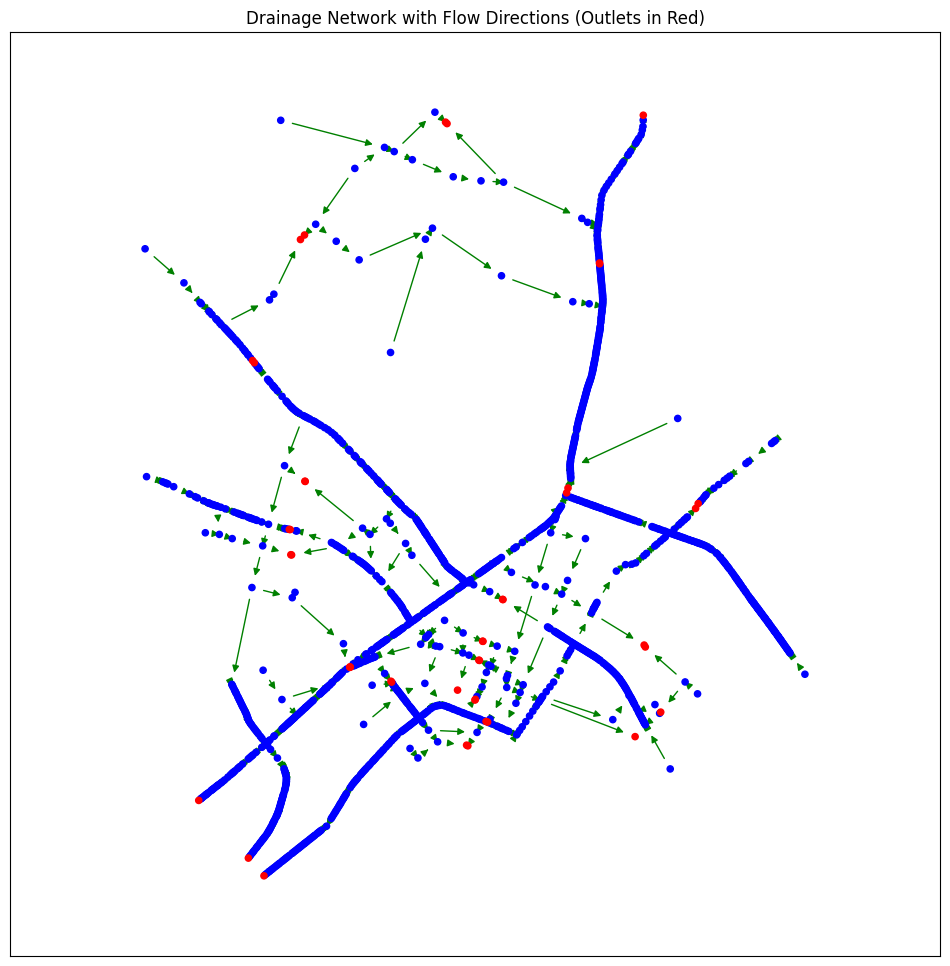

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Ensure each node has 'x' and 'y' attributes
for node, data in G_cleaned.nodes(data=True):
    point = nodes.loc[nodes['SWMM_NAME'] == node, 'geometry'].values[0]
    data['x'], data['y'] = point.x, point.y

# Prepare positions
pos = {node: (data['x'], data['y']) for node, data in G_cleaned.nodes(data=True)}

# Node colors: red for outlets, blue for others
node_colors = [
    'red' if node in outlets['SWMM_NAME'].values else 'blue'
    for node in G_cleaned.nodes()
]

plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G_cleaned, pos, node_size=20, node_color=node_colors)

# Draw edges with arrows
nx.draw_networkx_edges(
    G_cleaned, pos,
    edge_color='green',
    arrows=True,
    arrowsize=10,
    width=1
)

plt.title("Drainage Network with Flow Directions (Outlets in Red)")
plt.axis("equal")
plt.show()


In [24]:
# -------------------------
# Step 5: Assign Node Elevations and Pipe Slopes (Preserve Data Fidelity)
# -------------------------

import pandas as pd

print("Step 5: Assigning elevations and computing pipe slopes...")

# --- 1. Node elevations ---
# Ensure nodes have 'Inv_Elev' column
if "Inv_Elev" not in nodes.columns:
    raise RuntimeError("Node layer missing 'Inv_Elev' column.")

# Create mapping from node ID to invert elevation
node_elev = nodes.set_index("SWMM_NAME")["Inv_Elev"]

# --- 2. Assign From/To elevations to each pipe segment ---
split_pipes["FromElev"] = split_pipes["FromNode"].map(node_elev)
split_pipes["ToElev"]   = split_pipes["ToNode"].map(node_elev)

# --- 3. Compute pipe slopes (m/m) ---
split_pipes["Slope"] = (split_pipes["FromElev"] - split_pipes["ToElev"]) / split_pipes.geometry.length

# --- 4. Identify uphill or zero-slope pipes ---
uphill_pipes = split_pipes[split_pipes["Slope"] < 0]
zero_slope_pipes = split_pipes[split_pipes["Slope"] == 0]

print(f"⚠️ Found {len(uphill_pipes)} uphill pipes. Preserving original connectivity.")
if len(uphill_pipes) > 0:
    display(uphill_pipes[["SWMM_NAME", "FromNode", "ToNode", "FromElev", "ToElev", "Slope"]].head())

print(f"⚠️ Found {len(zero_slope_pipes)} zero-slope pipes.")
if len(zero_slope_pipes) > 0:
    display(zero_slope_pipes[["SWMM_NAME", "FromNode", "ToNode", "FromElev", "ToElev", "Slope"]].head())

# --- 5. Optional: Summary statistics ---
slope_summary = split_pipes["Slope"].describe()
print("\nPipe slope summary (m/m):")
print(slope_summary)

print("\n✅ Step 5 complete. All elevations preserved and slopes computed.")


Step 5: Assigning elevations and computing pipe slopes...
⚠️ Found 32 uphill pipes. Preserving original connectivity.


,SWMM_NAME,FromNode,ToNode,FromElev,ToElev,Slope
1148,C-43,I-77,I-75,1.88,2.11,-0.007485
1221,C-78,I-128,I-35,22.32,22.92,-0.012515
1280,C-23,I-48,I-52,2.70,2.76,-0.000743
1290,C-80,I-108,I-113,10.46,14.11,-0.040674
1303,C-79,I-108,I-112,10.46,11.71,-0.011700


⚠️ Found 0 zero-slope pipes.

Pipe slope summary (m/m):
count    139.000000
mean       0.009812
std        0.037407
min       -0.040674
25%        0.000091
50%        0.005653
75%        0.011399
max        0.415941
Name: Slope, dtype: float64

✅ Step 5 complete. All elevations preserved and slopes computed.


In [25]:
split_pipes

,OrigPipeIdx,SWMM_NAME,Diameter_m,pipe_manning,FromNode,ToNode,FromDist_m,ToDist_m,geometry,FromElev,ToElev,Slope
0,107,C-106,1.05,0.01,I-75,O-34,2.580034e+02,262.787324,"LINESTRING (603063.823 1141450.921, 603059.444...",2.11,2.077,0.006898
1,96,C-95,0.60,0.01,I-135,ISD-1072,0.000000e+00,5.007108,"LINESTRING (600809.489 1143246.755, 600809.566...",17.78,NaN,NaN
2,42,C-42,0.90,0.01,ISD-1161,ISD-1160,8.178419e+01,86.834863,"LINESTRING (602148.374 1143457.096, 602151.763...",NaN,NaN,NaN
3,35,C-35,1.20,0.01,ISD-1132,ISD-1131,9.297181e+01,98.701098,"LINESTRING (602534.994 1143032.631, 602538.123...",NaN,NaN,NaN
4,29,C-28,1.20,0.01,ISD-307,ISD-308,8.611989e+02,866.965580,"LINESTRING (604152.425 1141813.914, 604148.812...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1428,12,C-12,0.90,0.01,I-5,ISD-109,2.841300e-09,876.246328,"LINESTRING (601105.831 1142568.33, 601097.305 ...",14.59,NaN,NaN
1429,19,C-19,0.90,0.01,I-12,I-34,0.000000e+00,910.318548,"LINESTRING (601343.362 1146444.745, 601406.26 ...",30.49,30.010,0.000527
1430,122,C-121,0.80,0.01,I-11,O-6,0.000000e+00,945.688296,"LINESTRING (601286.318 1145002.472, 601315.739...",23.17,12.385,0.011404
1431,1,C-1,0.60,0.01,I-119,I-102,0.000000e+00,1082.727802,"LINESTRING (604636.651 1143971.528, 604540.997...",8.41,11.740,-0.003076


In [26]:
# Get the first edge (u, v) pair
first_edge = list(G_cleaned.edges())[0]

# Get its attributes
attrs = G_cleaned.edges[first_edge]

print("Edge:", first_edge)
print("Attributes:", attrs)


Edge: ('I-0', 'I-1')
Attributes: {'pipe_name': 'C-88', 'length': 488.2826844177916, 'diameter': 0.9, 'manning': 0.01, 'geometry': <LINESTRING (600217.965 1145378.849, 600281.279 1145378.048, 600315.742 1145...>, 'from_dist': 0.0, 'to_dist': 488.2826844177916, 'from_elev': None, 'to_elev': None}


In [27]:
# Get the first node ID
first_node = list(G_cleaned.nodes())[0]

# Get its attributes
attrs = G_cleaned.nodes[first_node]

print("Node ID:", first_node)
print("Attributes:", attrs)

Node ID: I-0
Attributes: {'inv_elev': 41.34, 'x': 600217.964978846, 'y': 1145378.8489606725}


NETWORK-BASED SUBCATCHMENT GENERATION

Total nodes: 1413
Total edges: 1428

Node classification:
  Headwater: 25
  Junction: 39
  Outfall: 45
  Intermediate: 1304

✓ Creating subcatchments for 1413 nodes
Outlets extent: [ 600217.96497885 1140177.15833275  605691.88955783 1146512.12202165]

STEP 1: ESTIMATING CONTRIBUTING AREAS FROM NETWORK

Inspecting edge attributes (first 5 edges):
  Edge 1: ['pipe_name', 'length', 'diameter', 'manning', 'geometry', 'from_dist', 'to_dist', 'from_elev', 'to_elev']
  Edge 2: ['pipe_name', 'length', 'diameter', 'manning', 'geometry', 'from_dist', 'to_dist', 'from_elev', 'to_elev']
  Edge 3: ['pipe_name', 'length', 'diameter', 'manning', 'geometry', 'from_dist', 'to_dist', 'from_elev', 'to_elev']
  Edge 4: ['pipe_name', 'length', 'diameter', 'manning', 'geometry', 'from_dist', 'to_dist', 'from_elev', 'to_elev']
  Edge 5: ['pipe_name', 'length', 'diameter', 'manning', 'geometry', 'from_dist', 'to_dist', 'from_elev', 'to_elev']

✓ Found length attribute: '

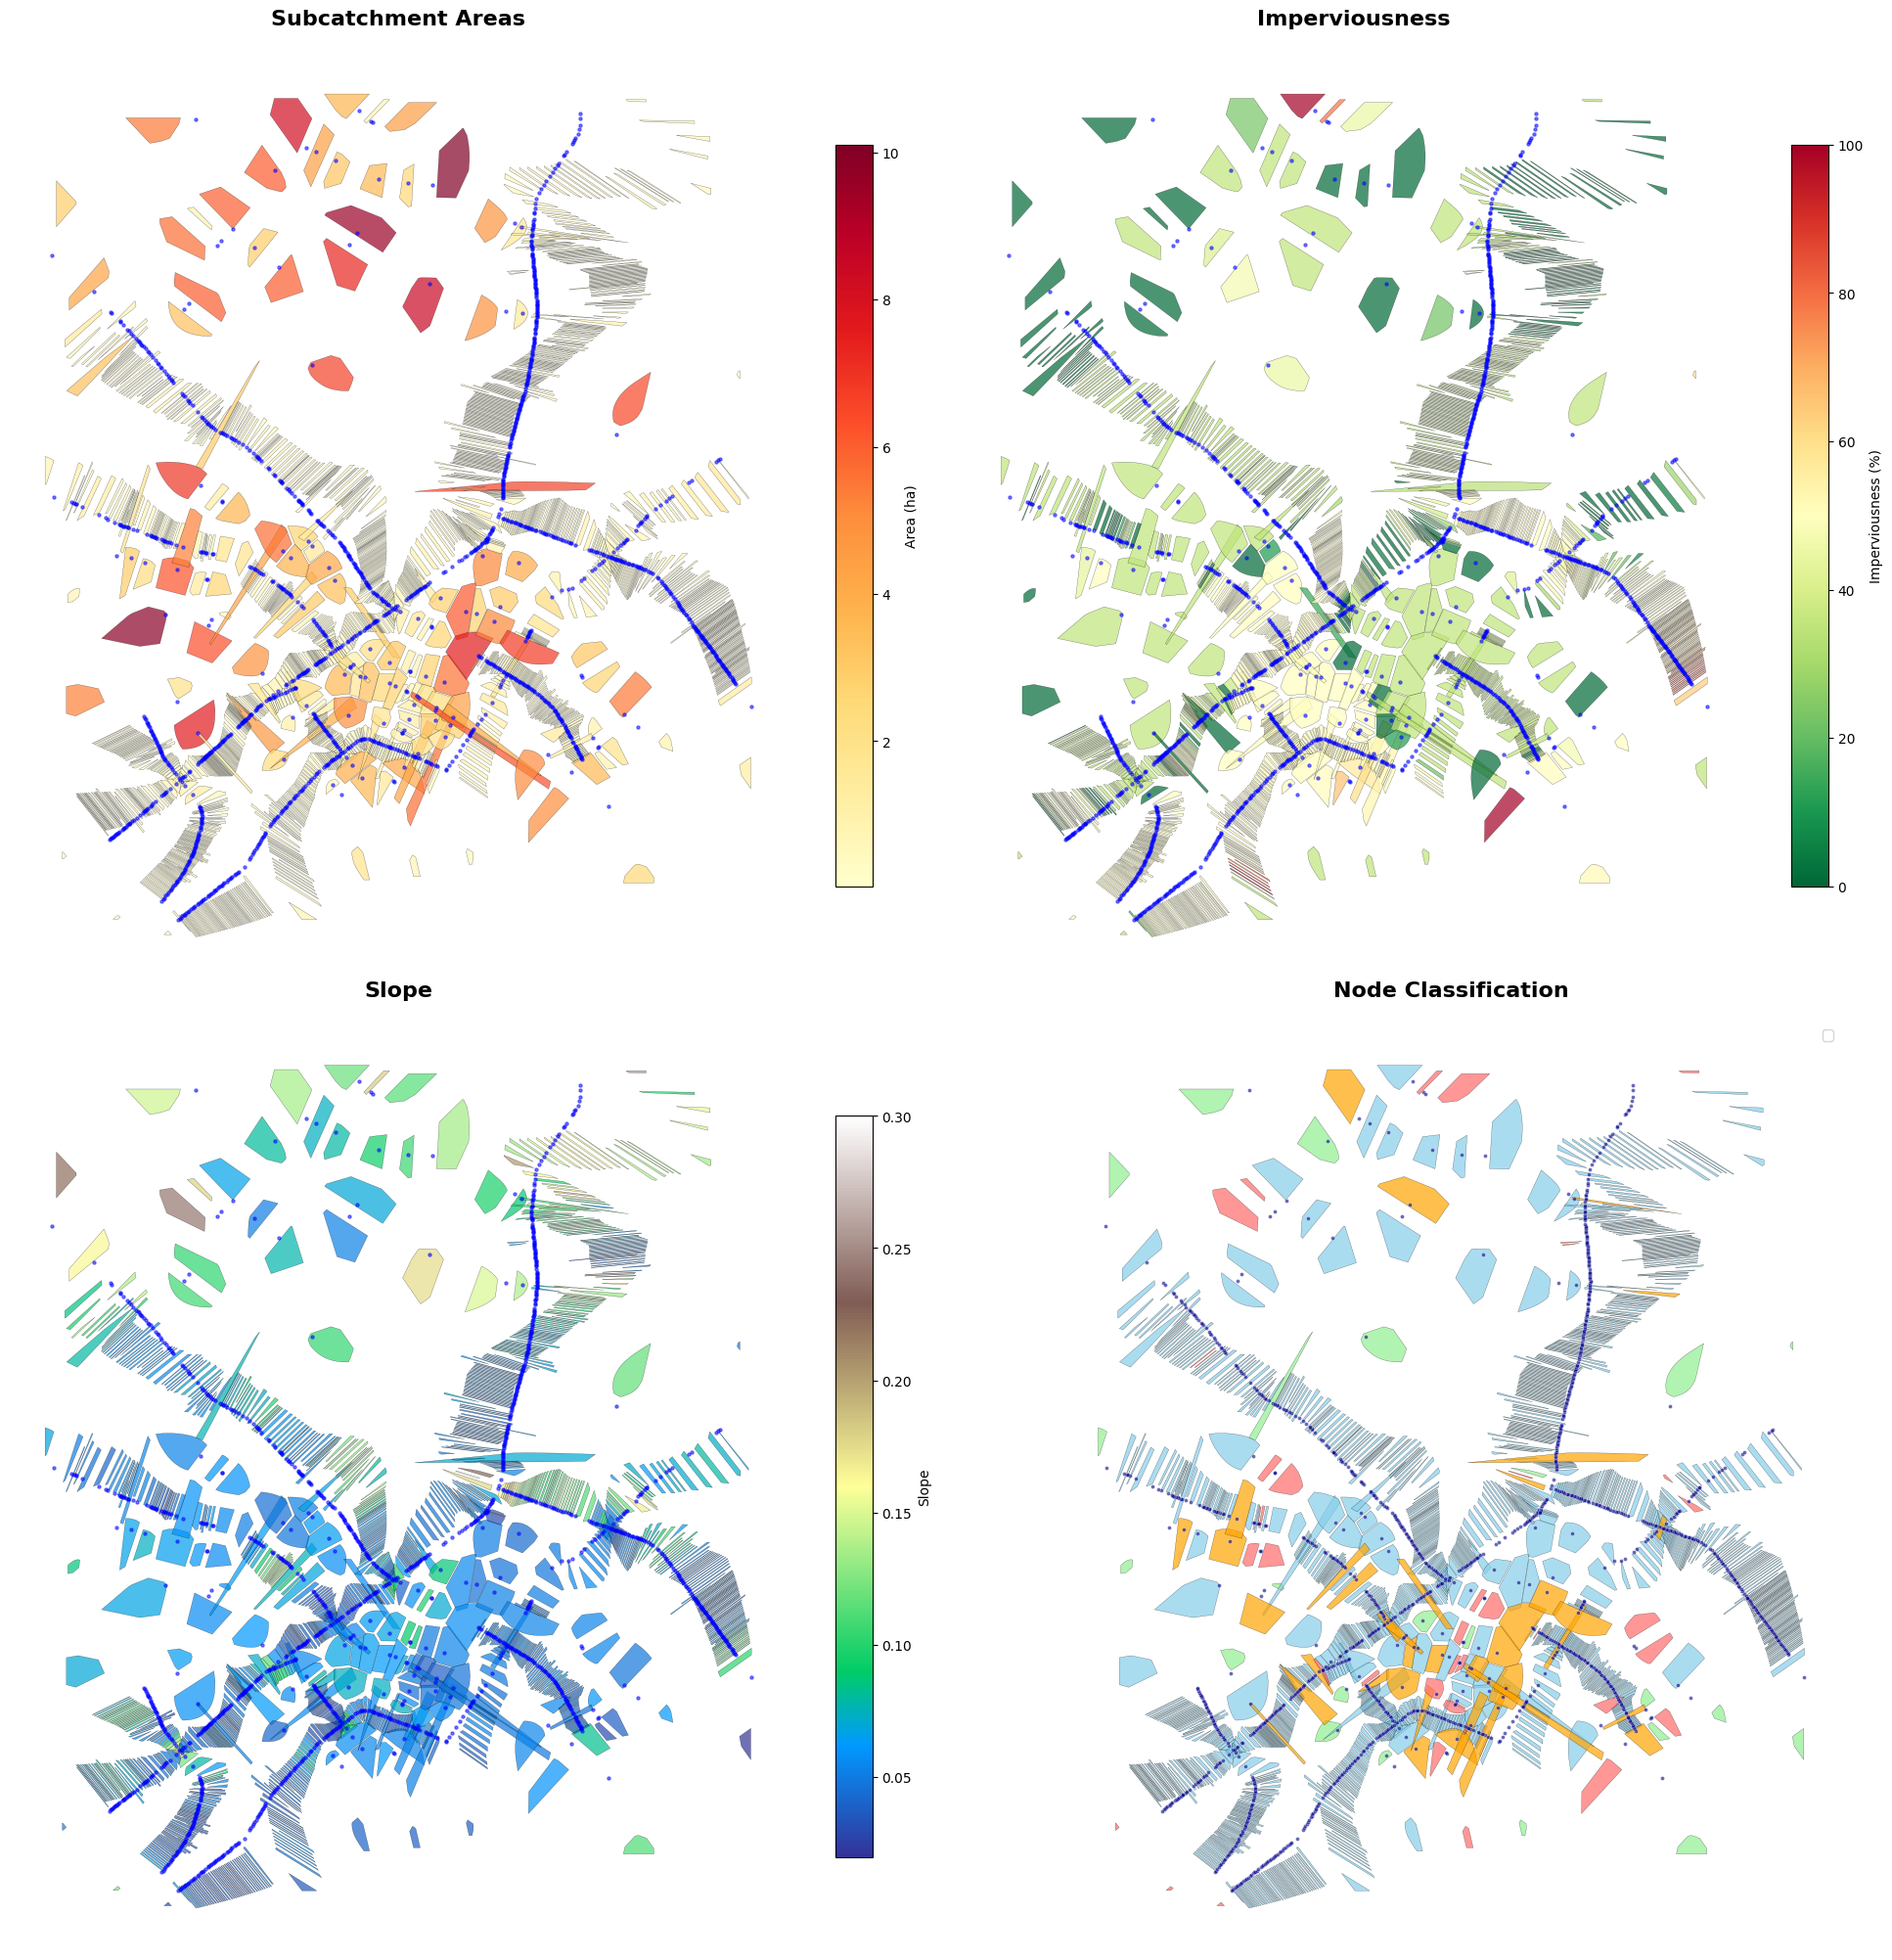


✅ COMPLETE - NETWORK-BASED SUBCATCHMENTS GENERATED

📁 Output files:
  1. /content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.shp
  2. /content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.inp
  3. /content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.csv
  4. /content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network_Map.png

💡 Method: Thiessen polygons scaled to network-derived areas
   - Areas estimated from pipe lengths × street width (40m)
   - Slope and imperviousness from DEM/Manning's n rasters
   - Each node gets exactly one subcatchment

🔍 Next steps:
  1. Load in QGIS to verify spatial distribution
  2. Check .inp file - areas should be realistic (0.02-1.0 ha typical)
  3. Import to SWMM and run test simulation
  4. Adjust BASE_SUBCATCHMENT_WIDTH (40m) if needed


In [28]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, box
from shapely.ops import unary_union, voronoi_diagram
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import warnings
warnings.filterwarnings('ignore')

# ---------- CONFIG ----------
DEM_PATH = "/content/drive/MyDrive/ML Surrogate Model/Mandaue_DEM.tif"
MANNING_PATH = "/content/drive/MyDrive/ML Surrogate Model/manning_mandaue_1.tif"
TARGET_CRS = "EPSG:32651"  # UTM Zone 51N

# Network-based subcatchment parameters
BASE_SUBCATCHMENT_WIDTH = 40  # meters (typical street width influence)
AREA_MULTIPLIER = 1.5  # Multiply pipe length by width for area
MIN_AREA_M2 = 200  # 0.02 ha minimum
DEFAULT_AREA_M2 = 800  # 0.08 ha default for nodes without pipes

# ---------- HELPER FUNCTIONS ----------

def calculate_pipe_length(G, node):
    """Calculate total pipe length connected to a node"""
    length = 0

    # Try different possible attribute names for pipe length
    length_attrs = ['Length', 'length', 'LENGTH', 'Len', 'len', 'L']

    # Upstream pipes (flowing INTO this node)
    for pred in G.predecessors(node):
        if G.has_edge(pred, node):
            edge_data = G[pred][node]
            for attr in length_attrs:
                if attr in edge_data:
                    length += edge_data[attr]
                    break

    # Downstream pipes (flowing OUT of this node)
    for succ in G.successors(node):
        if G.has_edge(node, succ):
            edge_data = G[node][succ]
            for attr in length_attrs:
                if attr in edge_data:
                    length += edge_data[attr]
                    break

    return length

def estimate_contributing_area(G, node, base_width=40):
    """Estimate contributing area based on pipe network"""
    pipe_length = calculate_pipe_length(G, node)

    if pipe_length > 0:
        # Area = pipe length × typical street width
        area = pipe_length * base_width * AREA_MULTIPLIER
        return max(area, MIN_AREA_M2)
    else:
        return DEFAULT_AREA_M2

def create_thiessen_polygons(points_gdf, boundary_buffer=200):
    """Create Thiessen polygons using Shapely's voronoi_diagram"""
    # Get all points
    points = points_gdf.geometry.tolist()

    # Create bounding box with buffer
    total_bounds = points_gdf.total_bounds
    bbox = box(
        total_bounds[0] - boundary_buffer,
        total_bounds[1] - boundary_buffer,
        total_bounds[2] + boundary_buffer,
        total_bounds[3] + boundary_buffer
    )

    # Create Voronoi diagram
    from shapely import MultiPoint
    multipoint = MultiPoint(points)
    voronoi_polys = voronoi_diagram(multipoint, envelope=bbox)

    # Extract individual polygons
    if voronoi_polys.geom_type == 'GeometryCollection':
        polygons = [geom for geom in voronoi_polys.geoms if isinstance(geom, Polygon)]
    else:
        polygons = [voronoi_polys]

    # Match polygons to points
    result = []
    for i, point in enumerate(points):
        for poly in polygons:
            if poly.contains(point) or point.within(poly.buffer(1)):
                result.append({
                    'node_id': points_gdf.iloc[i]['node_id'],
                    'geometry': poly.intersection(bbox),
                    'x': point.x,
                    'y': point.y
                })
                break

    return gpd.GeoDataFrame(result, crs=points_gdf.crs)

def extract_properties_from_raster(polygon, dem_array, manning_array, transform):
    """Extract slope and imperviousness from rasters"""
    try:
        minx, miny, maxx, maxy = polygon.bounds

        col_start = max(0, int((minx - transform[2]) / transform[0]))
        col_end = min(dem_array.shape[1], int((maxx - transform[2]) / transform[0]) + 1)
        row_start = max(0, int((maxy - transform[5]) / transform[4]))
        row_end = min(dem_array.shape[0], int((miny - transform[5]) / transform[4]) + 1)

        if row_start >= row_end or col_start >= col_end:
            return 0.005, 35.0

        # Extract and calculate slope
        dem_subset = dem_array[row_start:row_end, col_start:col_end]
        dem_valid = dem_subset[~np.isnan(dem_subset)]

        if dem_valid.size > 2:
            dy, dx = np.gradient(dem_subset)
            slope = np.nanmean(np.sqrt(dx**2 + dy**2))
            slope = max(min(slope, 0.3), 0.0005)
        else:
            slope = 0.005

        # Extract and calculate imperviousness
        manning_subset = manning_array[row_start:row_end, col_start:col_end]
        manning_valid = manning_subset[~np.isnan(manning_subset)]

        if manning_valid.size > 0:
            avg_manning = np.nanmean(manning_valid)
            if 0.01 < avg_manning < 0.06:
                perc_imperv = min(100, max(0, (0.045 - avg_manning) / 0.03 * 100))
            else:
                perc_imperv = 35.0
        else:
            perc_imperv = 35.0

        return slope, perc_imperv

    except:
        return 0.005, 35.0

def scale_subcatchment_by_area(polygon, target_area_m2):
    """Scale a polygon to match target area while preserving shape"""
    current_area = polygon.area
    if current_area < 1:
        return polygon

    scale_factor = np.sqrt(target_area_m2 / current_area)

    # Get centroid
    centroid = polygon.centroid

    # Scale around centroid
    from shapely import affinity
    scaled = affinity.scale(polygon, xfact=scale_factor, yfact=scale_factor, origin=centroid)

    return scaled

# ---------- ANALYZE NETWORK ----------
print("="*70)
print("NETWORK-BASED SUBCATCHMENT GENERATION")
print("="*70)
print(f"\nTotal nodes: {G_cleaned.number_of_nodes()}")
print(f"Total edges: {G_cleaned.number_of_edges()}")

# Classify nodes
node_types = {'headwater': [], 'junction': [], 'outfall': [], 'intermediate': []}

for node in G_cleaned.nodes():
    in_deg = G_cleaned.in_degree(node)
    out_deg = G_cleaned.out_degree(node)

    if in_deg > 0 and out_deg == 0:
        node_types['outfall'].append(node)
    elif in_deg == 0:
        node_types['headwater'].append(node)
    elif in_deg > 1:
        node_types['junction'].append(node)
    else:
        node_types['intermediate'].append(node)

print(f"\nNode classification:")
for ntype, nodes in node_types.items():
    print(f"  {ntype.capitalize()}: {len(nodes)}")

all_nodes = list(G_cleaned.nodes())
print(f"\n✓ Creating subcatchments for {len(all_nodes)} nodes")

# Create outlets GeoDataFrame
outlets_data = []
for node in all_nodes:
    attrs = G_cleaned.nodes[node]
    outlets_data.append({
        'node_id': node,
        'x': attrs['x'],
        'y': attrs['y'],
        'geometry': Point(attrs['x'], attrs['y'])
    })
outlets_gdf = gpd.GeoDataFrame(outlets_data, crs=TARGET_CRS)

print(f"Outlets extent: {outlets_gdf.total_bounds}")

# ---------- STEP 1: ESTIMATE AREAS ----------
print("\n" + "="*70)
print("STEP 1: ESTIMATING CONTRIBUTING AREAS FROM NETWORK")
print("="*70)

# First, check what edge attributes are available
sample_edges = list(G_cleaned.edges(data=True))[:5]
print(f"\nInspecting edge attributes (first 5 edges):")
for i, (u, v, data) in enumerate(sample_edges):
    print(f"  Edge {i+1}: {list(data.keys())}")

# Look for length attribute
length_attr_found = None
for attr in ['Length', 'length', 'LENGTH', 'Len', 'len', 'L', 'Shape_Length']:
    if any(attr in data for u, v, data in sample_edges):
        length_attr_found = attr
        print(f"\n✓ Found length attribute: '{length_attr_found}'")
        break

if not length_attr_found:
    print("\n⚠️ No length attribute found in edges!")
    print("   Will calculate length from node coordinates")

# Calculate areas with diagnostic info
node_areas = {}
nodes_with_pipes = 0
nodes_without_pipes = 0

for node in all_nodes:
    pipe_length = calculate_pipe_length(G_cleaned, node)

    if pipe_length > 0:
        area = pipe_length * BASE_SUBCATCHMENT_WIDTH * AREA_MULTIPLIER
        area = max(area, MIN_AREA_M2)
        nodes_with_pipes += 1
    else:
        # If no pipe length, calculate from node spacing
        # Find distance to nearest neighbor
        node_point = Point(G_cleaned.nodes[node]['x'], G_cleaned.nodes[node]['y'])
        min_dist = float('inf')

        for other_node in G_cleaned.nodes():
            if other_node != node:
                other_point = Point(G_cleaned.nodes[other_node]['x'],
                                   G_cleaned.nodes[other_node]['y'])
                dist = node_point.distance(other_point)
                if dist < min_dist:
                    min_dist = dist

        # Use nearest neighbor distance to estimate area
        if min_dist < float('inf'):
            # Area = circle with radius = half distance to nearest neighbor
            area = np.pi * (min_dist / 2) ** 2
            area = max(area, MIN_AREA_M2)
        else:
            area = DEFAULT_AREA_M2

        nodes_without_pipes += 1

    node_areas[node] = area

print(f"\nArea estimation results:")
print(f"  Nodes with pipe length data: {nodes_with_pipes}")
print(f"  Nodes using proximity estimation: {nodes_without_pipes}")

total_estimated_area = sum(node_areas.values()) / 1e6
areas_list = list(node_areas.values())
print(f"\nTotal estimated drainage area: {total_estimated_area:.3f} km²")
print(f"Average subcatchment size: {np.mean(areas_list) / 10000:.4f} ha")
print(f"Area range: {min(areas_list) / 10000:.4f} - {max(areas_list) / 10000:.4f} ha")
print(f"Area std dev: {np.std(areas_list) / 10000:.4f} ha")

# ---------- STEP 2: CREATE THIESSEN POLYGONS ----------
print("\n" + "="*70)
print("STEP 2: CREATING THIESSEN POLYGONS")
print("="*70)

print("Generating Voronoi tessellation...")
thiessen_gdf = create_thiessen_polygons(outlets_gdf, boundary_buffer=200)

if len(thiessen_gdf) != len(all_nodes):
    print(f"⚠️ Warning: Generated {len(thiessen_gdf)} polygons for {len(all_nodes)} nodes")
    # Fill missing nodes with small buffers
    existing_nodes = set(thiessen_gdf['node_id'])
    missing_nodes = set(all_nodes) - existing_nodes

    for node in missing_nodes:
        attrs = G_cleaned.nodes[node]
        point = Point(attrs['x'], attrs['y'])
        thiessen_gdf = pd.concat([
            thiessen_gdf,
            gpd.GeoDataFrame([{
                'node_id': node,
                'geometry': point.buffer(25),
                'x': attrs['x'],
                'y': attrs['y']
            }], crs=TARGET_CRS)
        ], ignore_index=True)

    print(f"  Added {len(missing_nodes)} buffer polygons for missing nodes")

print(f"✓ Created {len(thiessen_gdf)} Thiessen polygons")

# ---------- STEP 3: SCALE POLYGONS TO TARGET AREAS ----------
print("\n" + "="*70)
print("STEP 3: SCALING POLYGONS TO NETWORK-DERIVED AREAS")
print("="*70)

scaled_subcatchments = []

for idx, row in thiessen_gdf.iterrows():
    node_id = row['node_id']
    poly = row['geometry']
    target_area = node_areas[node_id]

    # Scale polygon to target area
    scaled_poly = scale_subcatchment_by_area(poly, target_area)

    # Ensure valid
    if not scaled_poly.is_valid:
        scaled_poly = scaled_poly.buffer(0)

    if isinstance(scaled_poly, MultiPolygon):
        scaled_poly = max(scaled_poly.geoms, key=lambda p: p.area)

    scaled_subcatchments.append({
        'node_id': node_id,
        'geometry': scaled_poly,
        'target_area': target_area,
        'actual_area': scaled_poly.area,
        'x': row['x'],
        'y': row['y']
    })

    if (idx + 1) % 200 == 0:
        print(f"  Scaled {idx+1}/{len(thiessen_gdf)}...")

subcatchments_gdf = gpd.GeoDataFrame(scaled_subcatchments, crs=TARGET_CRS)
print(f"✓ Scaled {len(subcatchments_gdf)} subcatchments")

# Check area accuracy
area_errors = [abs(row['actual_area'] - row['target_area']) / row['target_area'] * 100
               for _, row in subcatchments_gdf.iterrows()]
print(f"Area scaling accuracy: {np.mean(area_errors):.1f}% average error")

# ---------- STEP 4: LOAD RASTERS FOR PROPERTIES ----------
print("\n" + "="*70)
print("STEP 4: EXTRACTING SLOPE AND IMPERVIOUSNESS FROM RASTERS")
print("="*70)

dem = rasterio.open(DEM_PATH)
dem_array = dem.read(1)
manning_src = rasterio.open(MANNING_PATH)
manning_array = manning_src.read(1)

# Resample Manning if needed
if (manning_array.shape != dem_array.shape or
    manning_src.transform != dem.transform):
    print("Resampling Manning's n...")
    from rasterio.warp import reproject, Resampling
    manning_resampled = np.empty_like(dem_array)
    reproject(
        source=manning_array,
        destination=manning_resampled,
        src_transform=manning_src.transform,
        src_crs=manning_src.crs,
        dst_transform=dem.transform,
        dst_crs=dem.crs,
        resampling=Resampling.bilinear
    )
    manning_array = manning_resampled

# Transform subcatchments to DEM CRS
from pyproj import Transformer
transformer = Transformer.from_crs(TARGET_CRS, str(dem.crs), always_xy=True)

subcatchments_geo = subcatchments_gdf.to_crs(dem.crs)

# ---------- STEP 5: CALCULATE SWMM PARAMETERS ----------
print("\n" + "="*70)
print("STEP 5: CALCULATING SWMM PARAMETERS")
print("="*70)

swmm_subcatchments = []

for idx in range(len(subcatchments_gdf)):
    row_utm = subcatchments_gdf.iloc[idx]
    row_geo = subcatchments_geo.iloc[idx]

    node_id = row_utm.node_id
    poly_utm = row_utm.geometry
    poly_geo = row_geo.geometry

    # Area (from UTM)
    area_m2 = poly_utm.area
    area_ha = area_m2 / 10000

    # Width (characteristic width)
    width_m = np.sqrt(area_m2)

    # Extract slope and imperviousness
    slope, perc_imperv = extract_properties_from_raster(
        poly_geo, dem_array, manning_array, dem.transform
    )

    # Node type
    if node_id in node_types['outfall']:
        node_type = 'OUT'
    elif node_id in node_types['headwater']:
        node_type = 'HEAD'
    elif node_id in node_types['junction']:
        node_type = 'JCT'
    else:
        node_type = 'INT'

    swmm_subcatchments.append({
        'Name': f'SC_{node_id}',
        'Outlet': node_id,
        'NodeType': node_type,
        'Area_m2': area_m2,
        'Area_ha': area_ha,
        '%Imperv': perc_imperv,
        'Slope': slope,
        'Width': width_m,
        'geometry': poly_utm
    })

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx+1}/{len(subcatchments_gdf)}...")

print(f"✓ Calculated parameters for {len(swmm_subcatchments)} subcatchments")

# ---------- STEP 6: SAVE OUTPUTS ----------
print("\n" + "="*70)
print("STEP 6: SAVING OUTPUTS")
print("="*70)

final_gdf = gpd.GeoDataFrame(swmm_subcatchments, crs=TARGET_CRS)

# Shapefile
shp_path = "/content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.shp"
final_gdf.to_file(shp_path)
print(f"✓ Shapefile: {shp_path}")

# SWMM INP file
inp_lines = [
    "[SUBCATCHMENTS]",
    ";;Name           Outlet          Area     %Imperv  Width    Slope    CurbLen  SnowPack",
    ";;-------------- --------------- -------- -------- -------- -------- -------- --------"
]

for sc in swmm_subcatchments:
    inp_lines.append(
        f"{sc['Name']:<16} {sc['Outlet']:<15} {sc['Area_ha']:<8.4f} "
        f"{sc['%Imperv']:<8.2f} {sc['Width']:<8.2f} {sc['Slope']:<8.5f} 0"
    )

inp_path = "/content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.inp"
with open(inp_path, "w") as f:
    f.write("\n".join(inp_lines))
print(f"✓ SWMM input: {inp_path}")

# CSV details
csv_path = "/content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.csv"
final_gdf.drop(columns=['geometry']).to_csv(csv_path, index=False)
print(f"✓ Details CSV: {csv_path}")

# ---------- VALIDATION ----------
print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)

total_area_km2 = sum(sc['Area_m2'] for sc in swmm_subcatchments) / 1e6
areas_ha = [sc['Area_ha'] for sc in swmm_subcatchments]
impervs = [sc['%Imperv'] for sc in swmm_subcatchments]
slopes = [sc['Slope'] for sc in swmm_subcatchments]

print(f"\nTotal subcatchments: {len(swmm_subcatchments)}")
print(f"Total drainage area: {total_area_km2:.3f} km²")

print(f"\nArea statistics (hectares):")
print(f"  Min:    {min(areas_ha):.4f}")
print(f"  25th:   {np.percentile(areas_ha, 25):.4f}")
print(f"  Median: {np.median(areas_ha):.4f}")
print(f"  75th:   {np.percentile(areas_ha, 75):.4f}")
print(f"  Max:    {max(areas_ha):.4f}")
print(f"  Mean:   {np.mean(areas_ha):.4f}")

print(f"\nImperviousness statistics (%):")
print(f"  Min:    {min(impervs):.1f}")
print(f"  Median: {np.median(impervs):.1f}")
print(f"  Max:    {max(impervs):.1f}")
print(f"  Mean:   {np.mean(impervs):.1f}")

print(f"\nSlope statistics:")
print(f"  Min:    {min(slopes):.5f}")
print(f"  Median: {np.median(slopes):.5f}")
print(f"  Max:    {max(slopes):.5f}")
print(f"  Mean:   {np.mean(slopes):.5f}")

print(f"\nBy node type:")
for ntype in ['HEAD', 'INT', 'JCT', 'OUT']:
    count = sum(1 for sc in swmm_subcatchments if sc['NodeType'] == ntype)
    if count > 0:
        area_km2 = sum(sc['Area_m2'] for sc in swmm_subcatchments
                      if sc['NodeType'] == ntype) / 1e6
        avg_imperv = np.mean([sc['%Imperv'] for sc in swmm_subcatchments
                             if sc['NodeType'] == ntype])
        print(f"  {ntype}: {count} subcatchments, {area_km2:.3f} km², {avg_imperv:.1f}% imperv")

# Check for issues
zero_areas = sum(1 for sc in swmm_subcatchments if sc['Area_ha'] < 0.001)
if zero_areas > 0:
    print(f"\n⚠️ WARNING: {zero_areas} subcatchments have area < 0.001 ha")
else:
    print(f"\n✅ All subcatchments have valid areas")

# ---------- VISUALIZATION ----------
print("\n" + "="*70)
print("GENERATING MAPS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(20, 20))

# Map 1: Area distribution
ax1 = axes[0, 0]
final_gdf.plot(ax=ax1, column='Area_ha', cmap='YlOrRd', edgecolor='black',
              linewidth=0.2, alpha=0.7, legend=True,
              legend_kwds={'label': 'Area (ha)', 'shrink': 0.8})
outlets_gdf.plot(ax=ax1, color='blue', markersize=5, alpha=0.5, zorder=5)
ax1.set_title('Subcatchment Areas', fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Map 2: Imperviousness
ax2 = axes[0, 1]
final_gdf.plot(ax=ax2, column='%Imperv', cmap='RdYlGn_r', edgecolor='black',
              linewidth=0.2, alpha=0.7, legend=True,
              legend_kwds={'label': 'Imperviousness (%)', 'shrink': 0.8})
outlets_gdf.plot(ax=ax2, color='blue', markersize=5, alpha=0.5, zorder=5)
ax2.set_title('Imperviousness', fontsize=16, fontweight='bold', pad=20)
ax2.axis('off')

# Map 3: Slope
ax3 = axes[1, 0]
final_gdf.plot(ax=ax3, column='Slope', cmap='terrain', edgecolor='black',
              linewidth=0.2, alpha=0.7, legend=True,
              legend_kwds={'label': 'Slope', 'shrink': 0.8})
outlets_gdf.plot(ax=ax3, color='blue', markersize=5, alpha=0.5, zorder=5)
ax3.set_title('Slope', fontsize=16, fontweight='bold', pad=20)
ax3.axis('off')

# Map 4: Node types
ax4 = axes[1, 1]
type_colors = {'HEAD': '#90EE90', 'INT': '#87CEEB', 'JCT': '#FFA500', 'OUT': '#FF6B6B'}
for ntype, color in type_colors.items():
    subset = final_gdf[final_gdf['NodeType'] == ntype]
    if len(subset) > 0:
        subset.plot(ax=ax4, color=color, edgecolor='black', linewidth=0.2,
                   alpha=0.7, label=f'{ntype} ({len(subset)})')
outlets_gdf.plot(ax=ax4, color='darkblue', markersize=8, alpha=0.6, zorder=5,
                marker='o', edgecolors='white', linewidth=0.3)
ax4.set_title('Node Classification', fontsize=16, fontweight='bold', pad=20)
ax4.legend(loc='upper right', fontsize=10)
ax4.axis('off')

plt.tight_layout()
plot_path = '/content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network_Map.png'
plt.savefig(plot_path, dpi=200, bbox_inches='tight')
print(f"✓ Map: {plot_path}")
plt.show()

# Close files
manning_src.close()
dem.close()

print("\n" + "="*70)
print("✅ COMPLETE - NETWORK-BASED SUBCATCHMENTS GENERATED")
print("="*70)
print(f"\n📁 Output files:")
print(f"  1. {shp_path}")
print(f"  2. {inp_path}")
print(f"  3. {csv_path}")
print(f"  4. {plot_path}")
print(f"\n💡 Method: Thiessen polygons scaled to network-derived areas")
print(f"   - Areas estimated from pipe lengths × street width ({BASE_SUBCATCHMENT_WIDTH}m)")
print(f"   - Slope and imperviousness from DEM/Manning's n rasters")
print(f"   - Each node gets exactly one subcatchment")
print(f"\n🔍 Next steps:")
print(f"  1. Load in QGIS to verify spatial distribution")
print(f"  2. Check .inp file - areas should be realistic (0.02-1.0 ha typical)")
print(f"  3. Import to SWMM and run test simulation")
print(f"  4. Adjust BASE_SUBCATCHMENT_WIDTH ({BASE_SUBCATCHMENT_WIDTH}m) if needed")

EXTRACTING NODE ELEVATIONS FROM DEM

Converting nodes to GeoDataFrame...
✓ Created GeoDataFrame with 1413 nodes

Opening DEM...
  DEM CRS: EPSG:32651
  DEM shape: (9560, 6600)
  DEM bounds: BoundingBox(left=599930.0001220703, bottom=1139954.0001220703, right=606530.0001220703, top=1149514.0001220703)
  DEM nodata value: -3.4028230607370965e+38

CURRENT ELEVATION STATUS
Total nodes: 1413
Nodes with elevation: 0
Nodes missing elevation: 1413

✓ Identified 1413 nodes for elevation extraction

EXTRACTING ELEVATIONS FROM DEM
  Processed 100/1413...
  Processed 200/1413...
  Processed 300/1413...
  Processed 400/1413...
  Processed 500/1413...
  Processed 600/1413...
  Processed 700/1413...
  Processed 800/1413...
  Processed 900/1413...
  Processed 1000/1413...
  Processed 1100/1413...
  Processed 1200/1413...
  Processed 1300/1413...
  Processed 1400/1413...

✅ Successfully extracted 1413 elevations from DEM

FINAL ELEVATION STATISTICS
Total nodes: 1413
Nodes with valid elevations: 1413
No

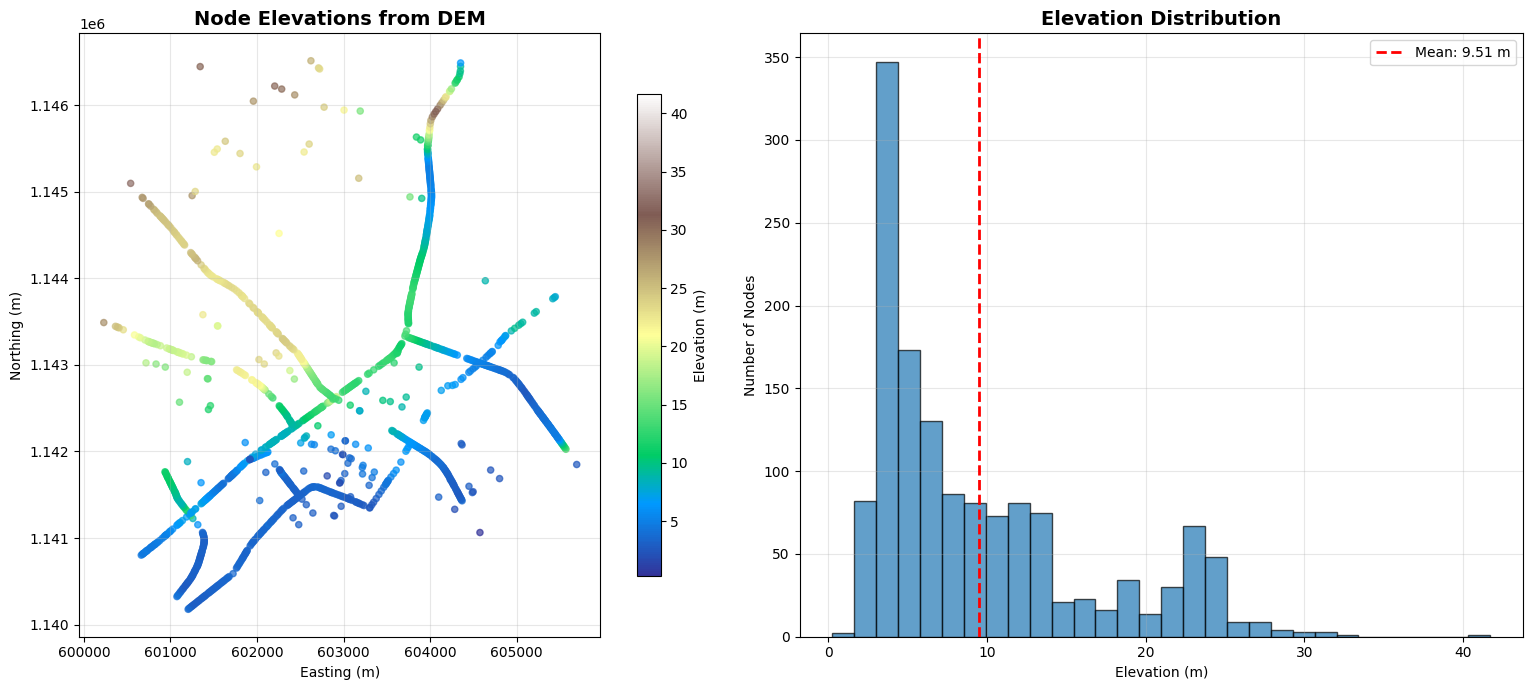


✅ ELEVATION EXTRACTION COMPLETE

📁 Output files:
  1. /content/drive/MyDrive/ML Surrogate Model/Nodes_With_Elevations.shp
  2. /content/drive/MyDrive/ML Surrogate Model/Node_Elevations.png

🔍 Next steps:
  1. Regenerate SWMM .inp file with updated elevations
  2. Check for negative slopes in conduits
  3. Run hydraulic simulation with improved vertical profile


In [29]:
"""
Extract node elevations from DEM for nodes with missing Inv_Elev
This improves model accuracy significantly
"""

import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer
import pandas as pd

DEM_PATH = "/content/drive/MyDrive/ML Surrogate Model/Mandaue_DEM.tif"
TARGET_CRS = "EPSG:32651"

print("="*70)
print("EXTRACTING NODE ELEVATIONS FROM DEM")
print("="*70)

# Convert nodes from NetworkX graph to GeoDataFrame
print("\nConverting nodes to GeoDataFrame...")
node_data = []
for node in G_cleaned.nodes():
    attrs = G_cleaned.nodes[node]
    node_data.append({
        'Node_ID': node,
        'x': attrs['x'],
        'y': attrs['y'],
        'Inv_Elev': attrs.get('Inv_Elev', np.nan),
        'geometry': Point(attrs['x'], attrs['y'])
    })

nodes_gdf = gpd.GeoDataFrame(node_data, crs=TARGET_CRS)
print(f"✓ Created GeoDataFrame with {len(nodes_gdf)} nodes")

# Open DEM
print("\nOpening DEM...")
dem = rasterio.open(DEM_PATH)
dem_array = dem.read(1)

print(f"  DEM CRS: {dem.crs}")
print(f"  DEM shape: {dem_array.shape}")
print(f"  DEM bounds: {dem.bounds}")
print(f"  DEM nodata value: {dem.nodata}")

# Create coordinate transformer
transformer = Transformer.from_crs(TARGET_CRS, str(dem.crs), always_xy=True)

# Analyze current elevation status
print("\n" + "="*70)
print("CURRENT ELEVATION STATUS")
print("="*70)

total_nodes = len(nodes_gdf)
missing_nodes = nodes_gdf['Inv_Elev'].isna().sum()
has_elev = total_nodes - missing_nodes

print(f"Total nodes: {total_nodes}")
print(f"Nodes with elevation: {has_elev}")
print(f"Nodes missing elevation: {missing_nodes}")

if has_elev > 0:
    valid_elevs = nodes_gdf[nodes_gdf['Inv_Elev'].notna()]['Inv_Elev']
    print(f"\nCurrent elevation stats:")
    print(f"  Min: {valid_elevs.min():.2f} m")
    print(f"  Max: {valid_elevs.max():.2f} m")
    print(f"  Mean: {valid_elevs.mean():.2f} m")
    print(f"  Median: {valid_elevs.median():.2f} m")

# Find nodes needing elevation extraction
# Option 1: Only missing values
nodes_to_fix = nodes_gdf[nodes_gdf['Inv_Elev'].isna()].copy()

# Option 2: Also fix suspicious values (uncomment if needed)
# suspicious_value = 10.28  # The default/average value
# nodes_to_fix = nodes_gdf[
#     nodes_gdf['Inv_Elev'].isna() |
#     (nodes_gdf['Inv_Elev'] == suspicious_value)
# ].copy()

print(f"\n✓ Identified {len(nodes_to_fix)} nodes for elevation extraction")

# Extract elevations
print("\n" + "="*70)
print("EXTRACTING ELEVATIONS FROM DEM")
print("="*70)

extracted_count = 0
oob_count = 0
invalid_count = 0

for idx in nodes_to_fix.index:
    node = nodes_gdf.loc[idx]
    x_utm, y_utm = node.geometry.x, node.geometry.y

    # Transform to DEM CRS (geographic)
    x_geo, y_geo = transformer.transform(x_utm, y_utm)

    # Check if within DEM bounds
    if not (dem.bounds.left <= x_geo <= dem.bounds.right and
            dem.bounds.bottom <= y_geo <= dem.bounds.top):
        oob_count += 1
        continue

    try:
        # Get pixel row, col
        row, col = dem.index(x_geo, y_geo)

        # Bounds check
        if 0 <= row < dem_array.shape[0] and 0 <= col < dem_array.shape[1]:
            elevation = dem_array[row, col]

            # Check if valid elevation
            if elevation != dem.nodata and not np.isnan(elevation):
                nodes_gdf.at[idx, 'Inv_Elev'] = float(elevation)
                extracted_count += 1
            else:
                invalid_count += 1
        else:
            oob_count += 1

    except Exception as e:
        invalid_count += 1

    # Progress update
    if (extracted_count + oob_count + invalid_count) % 100 == 0:
        print(f"  Processed {extracted_count + oob_count + invalid_count}/{len(nodes_to_fix)}...")

print(f"\n✅ Successfully extracted {extracted_count} elevations from DEM")
if oob_count > 0:
    print(f"⚠️ {oob_count} nodes outside DEM bounds")
if invalid_count > 0:
    print(f"⚠️ {invalid_count} nodes had invalid DEM values")

# Handle remaining missing values with spatial interpolation
still_missing = nodes_gdf[nodes_gdf['Inv_Elev'].isna()]

if len(still_missing) > 0:
    print("\n" + "="*70)
    print("INTERPOLATING REMAINING MISSING VALUES")
    print("="*70)
    print(f"⚠️ {len(still_missing)} nodes still missing elevations")
    print("Using nearest neighbor interpolation...")

    valid_nodes = nodes_gdf[nodes_gdf['Inv_Elev'].notna()]

    if len(valid_nodes) > 0:
        for idx in still_missing.index:
            node = nodes_gdf.loc[idx]

            # Calculate distances to all valid nodes
            distances = valid_nodes.geometry.distance(node.geometry)
            nearest_idx = distances.idxmin()
            nearest_elev = valid_nodes.loc[nearest_idx, 'Inv_Elev']

            nodes_gdf.at[idx, 'Inv_Elev'] = nearest_elev

        print(f"✓ Interpolated elevations for {len(still_missing)} nodes")
    else:
        print("⚠️ No valid elevations available for interpolation")
        print("   Using default value of 10.0 m")
        nodes_gdf.loc[still_missing.index, 'Inv_Elev'] = 10.0

# Close DEM
dem.close()

# Final statistics
print("\n" + "="*70)
print("FINAL ELEVATION STATISTICS")
print("="*70)

valid_count = nodes_gdf['Inv_Elev'].notna().sum()
still_missing_count = nodes_gdf['Inv_Elev'].isna().sum()

print(f"Total nodes: {len(nodes_gdf)}")
print(f"Nodes with valid elevations: {valid_count}")
print(f"Nodes still missing: {still_missing_count}")

if valid_count > 0:
    elevs = nodes_gdf['Inv_Elev'].dropna()
    print(f"\nElevation range: {elevs.min():.2f} - {elevs.max():.2f} m")
    print(f"Average elevation: {elevs.mean():.2f} m")
    print(f"Median elevation: {elevs.median():.2f} m")
    print(f"Std deviation: {elevs.std():.2f} m")

# Update the NetworkX graph with new elevations
print("\n" + "="*70)
print("UPDATING NETWORK GRAPH")
print("="*70)

updated_count = 0
for idx, row in nodes_gdf.iterrows():
    node_id = row['Node_ID']
    if node_id in G_cleaned.nodes():
        old_elev = G_cleaned.nodes[node_id].get('Inv_Elev', None)
        new_elev = row['Inv_Elev']

        if old_elev != new_elev:
            G_cleaned.nodes[node_id]['Inv_Elev'] = new_elev
            updated_count += 1

print(f"✓ Updated {updated_count} node elevations in graph")

# Save updated nodes to shapefile
output_path = "/content/drive/MyDrive/ML Surrogate Model/Nodes_With_Elevations.shp"
nodes_gdf.to_file(output_path)
print(f"✓ Saved nodes with elevations: {output_path}")

# Create elevation validation plot
print("\n" + "="*70)
print("GENERATING VALIDATION PLOT")
print("="*70)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Elevation map
ax1 = axes[0]
nodes_gdf.plot(ax=ax1, column='Inv_Elev', cmap='terrain',
               markersize=20, legend=True, alpha=0.7,
               legend_kwds={'label': 'Elevation (m)', 'shrink': 0.8})
ax1.set_title('Node Elevations from DEM', fontsize=14, fontweight='bold')
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.grid(True, alpha=0.3)

# Plot 2: Elevation histogram
ax2 = axes[1]
nodes_gdf['Inv_Elev'].dropna().hist(ax=ax2, bins=30, edgecolor='black', alpha=0.7)
ax2.set_title('Elevation Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Number of Nodes')
ax2.grid(True, alpha=0.3)
ax2.axvline(nodes_gdf['Inv_Elev'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {nodes_gdf["Inv_Elev"].mean():.2f} m')
ax2.legend()

plt.tight_layout()
plot_path = '/content/drive/MyDrive/ML Surrogate Model/Node_Elevations.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Saved elevation plot: {plot_path}")
plt.show()

print("\n" + "="*70)
print("✅ ELEVATION EXTRACTION COMPLETE")
print("="*70)
print("\n📁 Output files:")
print(f"  1. {output_path}")
print(f"  2. {plot_path}")
print("\n🔍 Next steps:")
print("  1. Regenerate SWMM .inp file with updated elevations")
print("  2. Check for negative slopes in conduits")
print("  3. Run hydraulic simulation with improved vertical profile")

In [30]:
"""
Final validation and cleanup before SWMM model generation
Ensures all data is consistent and ready for .inp file creation
"""

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import networkx as nx

print("="*70)
print("FINAL DATA VALIDATION FOR SWMM MODEL")
print("="*70)

# ============================================================================
# 1. CONVERT NETWORK TO DATAFRAMES
# ============================================================================
print("\n1. Converting Network Data to DataFrames...")

# Convert nodes from NetworkX to GeoDataFrame
node_data = []
for node in G_cleaned.nodes():
    attrs = G_cleaned.nodes[node]
    node_data.append({
        'SWMM_NAME': node,
        'x': attrs['x'],
        'y': attrs['y'],
        'Inv_Elev': attrs.get('Inv_Elev', np.nan),
        'MaxDepth': attrs.get('MaxDepth', 1.2),
        'geometry': Point(attrs['x'], attrs['y'])
    })

nodes_gdf = gpd.GeoDataFrame(node_data, crs='EPSG:32651')
print(f"✓ Created nodes GeoDataFrame: {len(nodes_gdf)} nodes")

# Convert edges to GeoDataFrame
edge_data = []
for u, v, data in G_cleaned.edges(data=True):
    edge_data.append({
        'SWMM_NAME': data.get('pipe_name', None),
        'FromNode': u,
        'ToNode': v,
        'Length': data.get('Length', data.get('length', 0)),
        'Diameter_m': data.get('Diameter', data.get('diameter', 0.6)),
        'pipe_manning': data.get('pipe_manning', data.get('pipe_manning', 0.013)),
        'geometry': data.get('geometry', None)
    })

pipes_gdf = gpd.GeoDataFrame(edge_data, crs='EPSG:32651')
print(f"✓ Created pipes GeoDataFrame: {len(pipes_gdf)} pipes")

# Load subcatchments (assuming already created)
try:
    subcatchments_gdf = gpd.read_file("/content/drive/MyDrive/ML Surrogate Model/Subcatchments_Network.shp")
    print(f"✓ Loaded subcatchments: {len(subcatchments_gdf)} subcatchments")
except:
    print("⚠️ Subcatchments shapefile not found - skipping subcatchment validation")
    subcatchments_gdf = None

# ============================================================================
# 2. VALIDATE NODES
# ============================================================================
print("\n" + "="*70)
print("2. VALIDATING NODES")
print("="*70)

# Check for missing elevations
missing_elev = nodes_gdf['Inv_Elev'].isna().sum()
if missing_elev > 0:
    print(f"⚠️ Found {missing_elev} nodes with missing elevations")

    # Strategy 1: Use average elevation
    if nodes_gdf['Inv_Elev'].notna().sum() > 0:
        avg_elev = nodes_gdf['Inv_Elev'].mean()
        nodes_gdf.loc[nodes_gdf['Inv_Elev'].isna(), 'Inv_Elev'] = avg_elev
        print(f"   → Assigned average elevation: {avg_elev:.2f} m")
    else:
        print("   → Assigning default elevation: 10.0 m")
        nodes_gdf['Inv_Elev'] = 10.0

    print(f"   💡 Tip: Run the elevation extraction script for better accuracy")
else:
    print("✓ All nodes have elevations")

# Check elevation statistics
elev_stats = nodes_gdf['Inv_Elev'].describe()
print(f"\nElevation statistics:")
print(f"  Min:    {elev_stats['min']:.2f} m")
print(f"  Mean:   {elev_stats['mean']:.2f} m")
print(f"  Max:    {elev_stats['max']:.2f} m")
print(f"  Std:    {elev_stats['std']:.2f} m")

# Identify node types
nodes_gdf['NodeType'] = 'Junction'
outfall_nodes = []
for node in G_cleaned.nodes():
    if G_cleaned.out_degree(node) == 0:
        nodes_gdf.loc[nodes_gdf['SWMM_NAME'] == node, 'NodeType'] = 'Outfall'
        outfall_nodes.append(node)

print(f"\nNode classification:")
print(f"  Junctions: {len(nodes_gdf[nodes_gdf['NodeType'] == 'Junction'])}")
print(f"  Outfalls:  {len(nodes_gdf[nodes_gdf['NodeType'] == 'Outfall'])}")

# Check for duplicate node names
duplicates = nodes_gdf[nodes_gdf['SWMM_NAME'].duplicated()]
if len(duplicates) > 0:
    print(f"\n⚠️ Found {len(duplicates)} duplicate node names - fixing")
    nodes_gdf['SWMM_NAME'] = nodes_gdf['SWMM_NAME'].astype(str) + '_' + nodes_gdf.index.astype(str)
    print("   → Added unique suffixes")
else:
    print("\n✓ No duplicate node names")

# Check MaxDepth
if nodes_gdf['MaxDepth'].isna().sum() > 0:
    nodes_gdf['MaxDepth'].fillna(1.2, inplace=True)
    print("✓ Filled missing MaxDepth with 3.0 m")

print(f"\n✅ Total nodes validated: {len(nodes_gdf)}")

# ============================================================================
# 3. VALIDATE PIPES
# ============================================================================
print("\n" + "="*70)
print("3. VALIDATING PIPES")
print("="*70)

# Check for missing connections
missing_conn = pipes_gdf[(pipes_gdf['FromNode'].isna()) | (pipes_gdf['ToNode'].isna())]
if len(missing_conn) > 0:
    print(f"⚠️ Found {len(missing_conn)} pipes with missing connections - removing")
    pipes_gdf = pipes_gdf.dropna(subset=['FromNode', 'ToNode'])

# Check that all referenced nodes exist
all_node_ids = set(nodes_gdf['SWMM_NAME'])
from_nodes = set(pipes_gdf['FromNode'])
to_nodes = set(pipes_gdf['ToNode'])
all_pipe_nodes = from_nodes.union(to_nodes)

orphaned_nodes = all_pipe_nodes - all_node_ids
if len(orphaned_nodes) > 0:
    print(f"⚠️ Found {len(orphaned_nodes)} nodes referenced in pipes but not in node list")
    print(f"   Example: {list(orphaned_nodes)[:5]}")
    pipes_gdf = pipes_gdf[
        pipes_gdf['FromNode'].isin(all_node_ids) &
        pipes_gdf['ToNode'].isin(all_node_ids)
    ]
    print(f"   → Removed {len(orphaned_nodes)} orphaned pipes")

# Calculate length if missing
if pipes_gdf['Length'].isna().sum() > 0 or (pipes_gdf['Length'] == 0).sum() > 0:
    print("\n⚠️ Some pipes have missing/zero length")
    for idx, row in pipes_gdf.iterrows():
        if pd.isna(row['Length']) or row['Length'] == 0:
            if row['geometry'] is not None:
                pipes_gdf.at[idx, 'Length'] = row['geometry'].length
            else:
                # Calculate from node coordinates
                from_node = nodes_gdf[nodes_gdf['SWMM_NAME'] == row['FromNode']]
                to_node = nodes_gdf[nodes_gdf['SWMM_NAME'] == row['ToNode']]
                if len(from_node) > 0 and len(to_node) > 0:
                    from_pt = from_node.iloc[0].geometry
                    to_pt = to_node.iloc[0].geometry
                    pipes_gdf.at[idx, 'Length'] = from_pt.distance(to_pt)
    print("   → Calculated lengths from geometry")

# Check for zero-length pipes
zero_length = pipes_gdf[pipes_gdf['Length'] < 0.1]
if len(zero_length) > 0:
    print(f"\n⚠️ Found {len(zero_length)} pipes < 0.1m length - removing")
    pipes_gdf = pipes_gdf[pipes_gdf['Length'] >= 0.1]

# Validate diameter
if pipes_gdf['Diameter_m'].isna().sum() > 0:
    print("\n⚠️ Some pipes missing diameter - using 0.6m default")
    pipes_gdf['Diameter_m'].fillna(0.6, inplace=True)

diam_issues = pipes_gdf[(pipes_gdf['Diameter_m'] < 0.1) | (pipes_gdf['Diameter_m'] > 5.0)]
if len(diam_issues) > 0:
    print(f"⚠️ Found {len(diam_issues)} pipes with unusual diameters (< 0.1m or > 5m)")

# Validate Manning's n
if pipes_gdf['pipe_manning'].isna().sum() > 0:
    pipes_gdf['pipe_manning'].fillna(0.013, inplace=True)
    print("✓ Filled missing Manning's n with 0.013")

manning_issues = pipes_gdf[(pipes_gdf['pipe_manning'] < 0.008) | (pipes_gdf['pipe_manning'] > 0.05)]
if len(manning_issues) > 0:
    print(f"⚠️ Found {len(manning_issues)} pipes with unusual Manning's n")
    pipes_gdf.loc[pipes_gdf['pipe_manning'] < 0.008, 'pipe_manning'] = 0.013
    pipes_gdf.loc[pipes_gdf['pipe_manning'] > 0.05, 'pipe_manning'] = 0.013

# Calculate slopes
print("\nCalculating pipe slopes...")
slopes = []
negative_slopes = 0

for idx, pipe in pipes_gdf.iterrows():
    from_node = nodes_gdf[nodes_gdf['SWMM_NAME'] == pipe['FromNode']]
    to_node = nodes_gdf[nodes_gdf['SWMM_NAME'] == pipe['ToNode']]

    if len(from_node) > 0 and len(to_node) > 0:
        from_elev = from_node.iloc[0]['Inv_Elev']
        to_elev = to_node.iloc[0]['Inv_Elev']
        length = pipe['Length']

        if length > 0:
            slope = (from_elev - to_elev) / length
            if slope < 0:
                negative_slopes += 1
                slope = 0.001  # Minimum slope
            slopes.append(slope)
        else:
            slopes.append(0.001)
    else:
        slopes.append(0.001)

pipes_gdf['Slope'] = slopes

if negative_slopes > 0:
    print(f"⚠️ Found {negative_slopes} pipes with negative slope (flow uphill)")
    print(f"   → Set to minimum slope 0.001")

print(f"\nPipe statistics:")
print(f"  Total pipes:      {len(pipes_gdf)}")
print(f"  Average length:   {pipes_gdf['Length'].mean():.1f} m")
print(f"  Total length:     {pipes_gdf['Length'].sum() / 1000:.2f} km")
print(f"  Average diameter: {pipes_gdf['Diameter_m'].mean() * 1000:.0f} mm")
print(f"  Average slope:    {pipes_gdf['Slope'].mean():.4f}")

print(f"\n✅ Total pipes validated: {len(pipes_gdf)}")

# ============================================================================
# 4. VALIDATE SUBCATCHMENTS
# ============================================================================
if subcatchments_gdf is not None:
    print("\n" + "="*70)
    print("4. VALIDATING SUBCATCHMENTS")
    print("="*70)

    # Check that all outlets exist
    missing_outlets = subcatchments_gdf[~subcatchments_gdf['Outlet'].isin(all_node_ids)]
    if len(missing_outlets) > 0:
        print(f"⚠️ Found {len(missing_outlets)} subcatchments with invalid outlets")
        subcatchments_gdf = subcatchments_gdf[subcatchments_gdf['Outlet'].isin(all_node_ids)]
        print(f"   → Removed invalid subcatchments")

    # Validate areas
    if 'Area_ha' not in subcatchments_gdf.columns and 'Area_m2' in subcatchments_gdf.columns:
        subcatchments_gdf['Area_ha'] = subcatchments_gdf['Area_m2'] / 10000

    area_issues = subcatchments_gdf[
        (subcatchments_gdf['Area_ha'] < 0.001) |
        (subcatchments_gdf['Area_ha'] > 1000)
    ]
    if len(area_issues) > 0:
        print(f"⚠️ Found {len(area_issues)} subcatchments with unusual areas")

    # Validate imperviousness
    if '%Imperv' in subcatchments_gdf.columns:
        subcatchments_gdf['%Imperv'] = subcatchments_gdf['%Imperv'].clip(0, 100)
    else:
        subcatchments_gdf['%Imperv'] = 35.0

    # Validate slope
    if 'Slope' in subcatchments_gdf.columns:
        subcatchments_gdf.loc[subcatchments_gdf['Slope'] <= 0, 'Slope'] = 0.001
    else:
        subcatchments_gdf['Slope'] = 0.005

    # Calculate width if missing
    if 'Width' not in subcatchments_gdf.columns:
        subcatchments_gdf['Width'] = np.sqrt(subcatchments_gdf['Area_m2'])

    print(f"\nSubcatchment statistics:")
    print(f"  Total subcatchments: {len(subcatchments_gdf)}")
    print(f"  Total area:          {subcatchments_gdf['Area_ha'].sum():.2f} ha ({subcatchments_gdf['Area_ha'].sum()/100:.2f} km²)")
    print(f"  Avg area:            {subcatchments_gdf['Area_ha'].mean():.4f} ha")
    print(f"  Avg imperviousness:  {subcatchments_gdf['%Imperv'].mean():.1f}%")
    print(f"  Avg slope:           {subcatchments_gdf['Slope'].mean():.4f}")

    # Check outlet distribution
    print(f"\nOutlet distribution:")
    outlet_counts = subcatchments_gdf['Outlet'].value_counts()
    multi_sub_outlets = outlet_counts[outlet_counts > 1]
    if len(multi_sub_outlets) > 0:
        print(f"  Outlets with multiple subcatchments: {len(multi_sub_outlets)}")
        print(f"  Max subcatchments per outlet: {multi_sub_outlets.max()}")

    print(f"\n✅ Total subcatchments validated: {len(subcatchments_gdf)}")

# ============================================================================
# 5. CHECK NETWORK CONNECTIVITY
# ============================================================================
print("\n" + "="*70)
print("5. CHECKING NETWORK CONNECTIVITY")
print("="*70)

# Check for isolated nodes
connected_nodes = from_nodes.union(to_nodes)
isolated_nodes = all_node_ids - connected_nodes

if len(isolated_nodes) > 0:
    print(f"⚠️ Found {len(isolated_nodes)} isolated nodes (not connected to any pipe)")
    print(f"   Example: {list(isolated_nodes)[:5]}")
else:
    print("✓ All nodes are connected to pipes")

# Check for disconnected subnetworks
print(f"\nNetwork structure:")
print(f"  Total nodes: {len(all_node_ids)}")
print(f"  Nodes in pipes: {len(connected_nodes)}")
print(f"  Outfall nodes: {len(outfall_nodes)}")

# Check connectivity to outfalls
reachable_from_outfalls = set()
for outfall in outfall_nodes:
    try:
        # Find all nodes that can reach this outfall
        predecessors = nx.ancestors(G_cleaned, outfall)
        reachable_from_outfalls.update(predecessors)
        reachable_from_outfalls.add(outfall)
    except:
        pass

unreachable = all_node_ids - reachable_from_outfalls
if len(unreachable) > 0:
    print(f"\n⚠️ Found {len(unreachable)} nodes that cannot reach any outfall")
    print(f"   These nodes form disconnected sub-networks")
else:
    print(f"\n✓ All nodes can reach an outfall")

# ============================================================================
# 6. SAVE VALIDATED DATA
# ============================================================================
print("\n" + "="*70)
print("6. SAVING VALIDATED DATA")
print("="*70)

output_dir = "/content/drive/MyDrive/ML Surrogate Model/"

# Save nodes
nodes_path = output_dir + "Validated_Nodes.shp"
nodes_gdf.to_file(nodes_path)
print(f"✓ Saved: {nodes_path}")

# Save pipes
pipes_path = output_dir + "Validated_Pipes.shp"
pipes_gdf.to_file(pipes_path)
print(f"✓ Saved: {pipes_path}")

# Save subcatchments if available
if subcatchments_gdf is not None:
    subs_path = output_dir + "Validated_Subcatchments.shp"
    subcatchments_gdf.to_file(subs_path)
    print(f"✓ Saved: {subs_path}")

# Save summary CSV
summary_data = {
    'Component': ['Nodes', 'Pipes', 'Subcatchments'],
    'Count': [
        len(nodes_gdf),
        len(pipes_gdf),
        len(subcatchments_gdf) if subcatchments_gdf is not None else 0
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_path = output_dir + "Validation_Summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"✓ Saved: {summary_path}")

# ============================================================================
# 7. FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("VALIDATION COMPLETE - MODEL READY FOR SWMM")
print("="*70)

print(f"\n📊 Model Summary:")
print(f"  Nodes:          {len(nodes_gdf):>6}")
print(f"    - Junctions:  {len(nodes_gdf[nodes_gdf['NodeType'] == 'Junction']):>6}")
print(f"    - Outfalls:   {len(nodes_gdf[nodes_gdf['NodeType'] == 'Outfall']):>6}")
print(f"  Pipes:          {len(pipes_gdf):>6}")
if subcatchments_gdf is not None:
    print(f"  Subcatchments:  {len(subcatchments_gdf):>6}")

print(f"\n📏 Network Metrics:")
if subcatchments_gdf is not None:
    print(f"  Drainage area:      {subcatchments_gdf['Area_ha'].sum() / 100:>8.2f} km²")
print(f"  Pipe length:        {pipes_gdf['Length'].sum() / 1000:>8.2f} km")
print(f"  Avg diameter:       {pipes_gdf['Diameter_m'].mean() * 1000:>8.0f} mm")
print(f"  Elevation range:    {nodes_gdf['Inv_Elev'].min():>8.2f} - {nodes_gdf['Inv_Elev'].max():.2f} m")

print("\n✅ All data validated and saved!")
print("\n🔜 Next step: Generate SWMM .inp file using the validated shapefiles")
print(f"   Files ready at: {output_dir}")

# Make validated data available globally
print("\n💡 Validated data loaded as:")
print("   - nodes_gdf")
print("   - pipes_gdf")
if subcatchments_gdf is not None:
    print("   - subcatchments_gdf")

FINAL DATA VALIDATION FOR SWMM MODEL

1. Converting Network Data to DataFrames...
✓ Created nodes GeoDataFrame: 1413 nodes
✓ Created pipes GeoDataFrame: 1428 pipes
✓ Loaded subcatchments: 1413 subcatchments

2. VALIDATING NODES
✓ All nodes have elevations

Elevation statistics:
  Min:    0.26 m
  Mean:   9.51 m
  Max:    41.70 m
  Std:    6.96 m

Node classification:
  Junctions: 1368
  Outfalls:  45

✓ No duplicate node names

✅ Total nodes validated: 1413

3. VALIDATING PIPES
⚠️ Found 1 pipes with unusual diameters (< 0.1m or > 5m)

Calculating pipe slopes...
⚠️ Found 513 pipes with negative slope (flow uphill)
   → Set to minimum slope 0.001

Pipe statistics:
  Total pipes:      1428
  Average length:   45.1 m
  Total length:     64.43 km
  Average diameter: 816 mm
  Average slope:    0.0068

✅ Total pipes validated: 1428

4. VALIDATING SUBCATCHMENTS

Subcatchment statistics:
  Total subcatchments: 1413
  Total area:          773.13 ha (7.73 km²)
  Avg area:            0.5472 ha
  A

In [31]:
pipes_gdf.head()

,SWMM_NAME,FromNode,ToNode,Length,Diameter_m,pipe_manning,geometry,Slope
0,C-88,I-0,I-1,488.282684,0.9,0.013,"LINESTRING (600217.965 1145378.849, 600281.279...",0.018964
1,C-139,I-1,ISD-1238,223.908970,0.6,0.013,"LINESTRING (600540.381 1145096.268, 600552.97 ...",0.021375
2,C-125,I-2,I-4,115.703404,0.6,0.013,"LINESTRING (600833.869 1143009.59, 600857.117 ...",0.002679
3,C-109,I-3,ISD-1232,37.301438,0.6,0.013,"LINESTRING (600850.676 1144750.304, 600876.36 ...",0.007238
4,C-16,I-3,I-10,494.018036,0.2,0.013,"LINESTRING (600848.927 1144748.644, 600892.004...",0.001000


In [32]:
"""
Complete SWMM .inp File Generator
Generates a full SWMM5 input file from the processed drainage network and subcatchments
"""

import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime

# ============================================================================
# PART 1: HEADER SECTIONS
# ============================================================================

def write_title_section():
    """Generate [TITLE] section"""
    return """[TITLE]
;;Project Title/Notes
Mandaue City Drainage Network Model
Generated from GIS data
{date}
""".format(date=datetime.now().strftime("%Y-%m-%d %H:%M"))

def write_options_section():
    """Generate [OPTIONS] section"""
    return """[OPTIONS]
;;Option             Value
FLOW_UNITS           CMS
INFILTRATION         HORTON
FLOW_ROUTING         DYNWAVE
LINK_OFFSETS         DEPTH
MIN_SLOPE            0
ALLOW_PONDING        YES
SKIP_STEADY_STATE    NO

START_DATE           01/01/2024
START_TIME           00:00:00
REPORT_START_DATE    01/01/2024
REPORT_START_TIME    00:00:00
END_DATE             01/02/2024
END_TIME             00:00:00
SWEEP_START          01/01
SWEEP_END            12/31
DRY_DAYS             0
REPORT_STEP          00:15:00
WET_STEP             00:05:00
DRY_STEP             01:00:00
ROUTING_STEP         0:00:10

RULE_STEP            00:00:00
INERTIAL_DAMPING     PARTIAL
NORMAL_FLOW_LIMITED  BOTH
FORCE_MAIN_EQUATION  H-W
VARIABLE_STEP        0.75
LENGTHENING_STEP     0
MIN_SURFAREA         12.566
MAX_TRIALS           8
HEAD_TOLERANCE       0.0015
SYS_FLOW_TOL         5
LAT_FLOW_TOL         5
MINIMUM_STEP         0.5
THREADS              1
"""

def write_report_section():
    """Generate [REPORT] section"""
    return """[REPORT]
;;Reporting Options
INPUT      NO
CONTINUITY YES
FLOWSTATS  YES
CONTROLS   NO
SUBCATCHMENTS ALL
NODES ALL
LINKS ALL
"""

# ============================================================================
# PART 2: HYDROLOGIC ELEMENTS
# ============================================================================

def write_subcatchments_section(subcatchments_gdf):
    """Generate [SUBCATCHMENTS] section from GeoDataFrame"""
    lines = ["[SUBCATCHMENTS]"]
    lines.append(";;Name           Rain Gage        Outlet           Area     %Imperv  Width    %Slope   CurbLen  SnowPack")
    lines.append(";;--------------  ----------------  ----------------  --------  --------  --------  --------  --------  --------")

    for idx, row in subcatchments_gdf.iterrows():
        # Convert to float in case stored as string
        area_m2 = float(row['Area_m2'])
        imperv = float(row['%Imperv'])
        slope = float(row['Slope'])

        area_ha = area_m2 / 10000
        width_m = np.sqrt(area_m2)

        line = (f"{row['Name']:<16} RG1              {row['Outlet']:<16}  "
                f"{area_ha:<8.3f}  {imperv:<8.1f}  {width_m:<8.1f}  "
                f"{slope:<8.4f}  0        ")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_subareas_section(subcatchments_gdf):
    """Generate [SUBAREAS] section"""
    lines = ["[SUBAREAS]"]
    lines.append(";;Subcatchment   N-Imperv   N-Perv     S-Imperv   S-Perv     PctZero    RouteTo    PctRouted")
    lines.append(";;--------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------")

    for idx, row in subcatchments_gdf.iterrows():
        # Typical urban values
        line = (f"{row['Name']:<16} 0.015      0.15       2.0        5.0        25         "
                f"OUTLET     100")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_infiltration_section(subcatchments_gdf):
    """Generate [INFILTRATION] section (Horton parameters)"""
    lines = ["[INFILTRATION]"]
    lines.append(";;Subcatchment   MaxRate    MinRate    Decay      DryTime    MaxInfil")
    lines.append(";;--------------  ----------  ----------  ----------  ----------  ----------")

    for idx, row in subcatchments_gdf.iterrows():
        # Horton parameters vary by imperviousness
        imperv = float(row['%Imperv'])

        # More impervious = lower infiltration
        if imperv > 70:
            max_rate, min_rate = 50, 5
        elif imperv > 40:
            max_rate, min_rate = 75, 10
        else:
            max_rate, min_rate = 100, 15

        line = (f"{row['Name']:<16} {max_rate:<10.1f}  {min_rate:<10.1f}  "
                f"4.0        7.0        0")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_raingages_section():
    """Generate [RAINGAGES] section"""
    return """[RAINGAGES]
;;Name           Format    Interval SCF      Source
;;--------------  --------  ------  ------  ----------
RG1              INTENSITY 0:05    1.0     TIMESERIES TS_Rain

"""

def write_timeseries_section():
    """Generate [TIMESERIES] section with design storm"""
    return """[TIMESERIES]
;;Name           Date       Time       Value
;;--------------  ----------  ----------  ----------
;; 100-year, 3-hour design storm (SCS Type II distribution)
;; Peak intensity occurs at 60% of duration
;; Total rainfall: ~250mm (typical for Philippines 100-yr event)
TS_Rain                      0:00       5
TS_Rain                      0:10       8
TS_Rain                      0:20       12
TS_Rain                      0:30       18
TS_Rain                      0:40       25
TS_Rain                      0:50       35
TS_Rain                      1:00       50
TS_Rain                      1:10       75
TS_Rain                      1:20       120
TS_Rain                      1:30       200
TS_Rain                      1:40       350
TS_Rain                      1:50       180
TS_Rain                      2:00       100
TS_Rain                      2:10       60
TS_Rain                      2:20       40
TS_Rain                      2:30       25
TS_Rain                      2:40       15
TS_Rain                      2:50       10
TS_Rain                      3:00       5

"""

# ============================================================================
# PART 3: HYDRAULIC ELEMENTS
# ============================================================================

def write_junctions_section(nodes_gdf):
    """Generate [JUNCTIONS] section"""
    lines = ["[JUNCTIONS]"]
    lines.append(";;Name           Elevation  MaxDepth   InitDepth  SurDepth   Aponded")
    lines.append(";;--------------  ----------  ----------  ----------  ----------  ----------")

    # Filter for junctions (not outfalls)
    junctions = nodes_gdf[~nodes_gdf['SWMM_NAME'].str.startswith('O-')].copy()

    for idx, row in junctions.iterrows():
        inv_elev = row.get('Inv_Elev', 0)
        max_depth = row.get('MaxDepth', 1.2)

        line = (f"{row['SWMM_NAME']:<16} {inv_elev:<10.2f}  {max_depth:<10.2f}  "
                f"0          0          0")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_outfalls_section(nodes_gdf):
    """Generate [OUTFALLS] section"""
    lines = ["[OUTFALLS]"]
    lines.append(";;Name           Elevation  Type       Stage Data       Gated    Route To")
    lines.append(";;--------------  ----------  ----------  ----------------  -------- ----------------")

    # Filter for outfalls
    outfalls = nodes_gdf[nodes_gdf['SWMM_NAME'].str.startswith('O-')].copy()

    for idx, row in outfalls.iterrows():
        inv_elev = row.get('Inv_Elev', 0)

        line = (f"{row['SWMM_NAME']:<16} {inv_elev:<10.2f}  FREE                         "
                f"NO       ")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_conduits_section(pipes_gdf):
    """Generate [CONDUITS] section"""
    lines = ["[CONDUITS]"]
    lines.append(";;Name           From Node        To Node          Length     Roughness  InOffset   OutOffset  InitFlow   MaxFlow")
    lines.append(";;--------------  ----------------  ----------------  ----------  ----------  ----------  ----------  ----------  ----------")

    for idx, row in pipes_gdf.iterrows():
        # Generate unique conduit name
        conduit_name = f"C_{idx}-{row['SWMM_NAME']}"



        length = row.geometry.length
        roughness = row.get('pipe_manning', 0.013)

        # Use computed elevations for offsets (difference from node invert)
        in_offset = 0.0
        out_offset = 0.0

        line = (f"{conduit_name:<16} {row['FromNode']:<16}  {row['ToNode']:<16}  "
                f"{length:<10.2f}  {roughness:<10.4f}  {in_offset:<10.2f}  "
                f"{out_offset:<10.2f}  0          0")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_xsections_section(pipes_gdf):
    """Generate [XSECTIONS] section"""
    lines = ["[XSECTIONS]"]
    lines.append(";;Link           Shape        Geom1            Geom2      Geom3      Geom4      Barrels    Culvert")
    lines.append(";;--------------  ------------  ----------------  ----------  ----------  ----------  ----------  ----------")

    for idx, row in pipes_gdf.iterrows():
        conduit_name = f"C_{idx}-{row['SWMM_NAME']}"

        # Get diameter (convert to meters if needed)
        diameter = row.get('Diameter_m', 0.6)

        line = (f"{conduit_name:<16} CIRCULAR     {diameter:<16.3f}  0          0          0          "
                f"1          ")
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

# ============================================================================
# PART 4: COORDINATES AND MAP
# ============================================================================

def write_coordinates_section(nodes_gdf):
    """Generate [COORDINATES] section"""
    lines = ["[COORDINATES]"]
    lines.append(";;Node           X-Coord            Y-Coord")
    lines.append(";;--------------  ------------------  ------------------")

    for idx, row in nodes_gdf.iterrows():
        x, y = row.geometry.x, row.geometry.y
        line = f"{row['SWMM_NAME']:<16} {x:<18.6f}  {y:<18.6f}"
        lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_vertices_section(pipes_gdf):
    """Generate [VERTICES] section for pipe intermediate points"""
    lines = ["[VERTICES]"]
    lines.append(";;Link           X-Coord            Y-Coord")
    lines.append(";;--------------  ------------------  ------------------")

    for idx, row in pipes_gdf.iterrows():
        conduit_name = f"C_{idx}-{row['SWMM_NAME']}"

        # Get intermediate vertices (exclude first and last points)
        coords = list(row.geometry.coords)
        if len(coords) > 2:
            for x, y in coords[1:-1]:
                line = f"{conduit_name:<16} {x:<18.6f}  {y:<18.6f}"
                lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_polygons_section(subcatchments_gdf):
    """Generate [POLYGONS] section for subcatchment boundaries"""
    lines = ["[POLYGONS]"]
    lines.append(";;Subcatchment   X-Coord            Y-Coord")
    lines.append(";;--------------  ------------------  ------------------")

    for idx, row in subcatchments_gdf.iterrows():
        # Get exterior coordinates of polygon
        if row.geometry.geom_type == 'Polygon':
            coords = list(row.geometry.exterior.coords)
            for x, y in coords:
                line = f"{row['Name']:<16} {x:<18.6f}  {y:<18.6f}"
                lines.append(line)

    lines.append("")
    return "\n".join(lines)

def write_symbols_section(nodes_gdf):
    """Generate [SYMBOLS] section for rain gages"""
    # Place rain gage at centroid of network
    centroid_x = nodes_gdf.geometry.x.mean()
    centroid_y = nodes_gdf.geometry.y.mean()

    return f"""[SYMBOLS]
;;Gage           X-Coord            Y-Coord
;;--------------  ------------------  ------------------
RG1              {centroid_x:<18.6f}  {centroid_y:<18.6f}

"""

def write_tags_section():
    """Generate [TAGS] section"""
    return """[TAGS]

"""

# ============================================================================
# MAIN GENERATOR
# ============================================================================

def generate_complete_swmm_inp(nodes_gdf, pipes_gdf, subcatchments_gdf, output_path):
    """
    Generate complete SWMM .inp file

    Parameters:
    -----------
    nodes_gdf : GeoDataFrame
        All nodes (junctions and outfalls)
    pipes_gdf : GeoDataFrame
        All pipe segments with FromNode and ToNode
    subcatchments_gdf : GeoDataFrame
        Subcatchments with Area, %Imperv, Slope
    output_path : str
        Path to save .inp file
    """

    print("Generating SWMM .inp file...")

    sections = []

    # Header sections
    sections.append(write_title_section())
    sections.append(write_options_section())
    sections.append(write_report_section())

    # Climate/hydrology
    sections.append(write_raingages_section())
    sections.append(write_timeseries_section())

    # Subcatchments
    sections.append(write_subcatchments_section(subcatchments_gdf))
    sections.append(write_subareas_section(subcatchments_gdf))
    sections.append(write_infiltration_section(subcatchments_gdf))

    # Nodes
    sections.append(write_junctions_section(nodes_gdf))
    sections.append(write_outfalls_section(nodes_gdf))

    # Links
    sections.append(write_conduits_section(pipes_gdf))
    sections.append(write_xsections_section(pipes_gdf))

    # Map/graphics
    sections.append(write_coordinates_section(nodes_gdf))
    sections.append(write_vertices_section(pipes_gdf))
    sections.append(write_polygons_section(subcatchments_gdf))

    # Add symbols and tags
    sections.append(write_symbols_section(nodes_gdf))
    sections.append(write_tags_section())

    # Combine all sections
    full_inp = "\n".join(sections)

    # Write to file
    final_path = '/content/drive/MyDrive/ML Surrogate Model/Mandaue_Drainage_Network.inp'
    with open(final_path, 'w') as f:
        f.write(full_inp)

    print(f"✅ SWMM .inp file written to: {final_path}")

    # Print summary
    print("\n" + "="*60)
    print("MODEL SUMMARY")
    print("="*60)
    print(f"Subcatchments: {len(subcatchments_gdf)}")
    print(f"Junctions: {len(nodes_gdf[~nodes_gdf['SWMM_NAME'].str.startswith('O-')])}")
    print(f"Outfalls: {len(nodes_gdf[nodes_gdf['SWMM_NAME'].str.startswith('O-')])}")
    print(f"Conduits: {len(pipes_gdf)}")

    # Convert to numeric for summary stats
    total_area = pd.to_numeric(subcatchments_gdf['Area_m2'], errors='coerce').sum()
    avg_imperv = pd.to_numeric(subcatchments_gdf['%Imperv'], errors='coerce').mean()

    print(f"\nTotal drainage area: {total_area / 1e6:.2f} km²")
    print(f"Average imperviousness: {avg_imperv:.1f}%")

    return full_inp


In [33]:
nodes_gdf.head()

,SWMM_NAME,x,y,Inv_Elev,MaxDepth,geometry,NodeType
0,I-0,600217.964979,1.145379e+06,41.696548,1.2,POINT (600217.965 1145378.849),Junction
1,I-1,600540.381331,1.145096e+06,32.436558,1.2,POINT (600540.381 1145096.268),Junction
2,I-2,600833.866798,1.143010e+06,16.407938,1.2,POINT (600833.867 1143009.582),Junction
3,I-3,600848.927305,1.144749e+06,25.060453,1.2,POINT (600848.927 1144748.644),Junction
4,I-4,600940.790325,1.142975e+06,16.097940,1.2,POINT (600940.79 1142974.635),Junction


In [34]:
split_pipes.head()

,OrigPipeIdx,SWMM_NAME,Diameter_m,pipe_manning,FromNode,ToNode,FromDist_m,ToDist_m,geometry,FromElev,ToElev,Slope
0,107,C-106,1.05,0.01,I-75,O-34,258.003380,262.787324,"LINESTRING (603063.823 1141450.921, 603059.444...",2.11,2.077,0.006898
1,96,C-95,0.60,0.01,I-135,ISD-1072,0.000000,5.007108,"LINESTRING (600809.489 1143246.755, 600809.566...",17.78,NaN,NaN
2,42,C-42,0.90,0.01,ISD-1161,ISD-1160,81.784188,86.834863,"LINESTRING (602148.374 1143457.096, 602151.763...",NaN,NaN,NaN
3,35,C-35,1.20,0.01,ISD-1132,ISD-1131,92.971813,98.701098,"LINESTRING (602534.994 1143032.631, 602538.123...",NaN,NaN,NaN
4,29,C-28,1.20,0.01,ISD-307,ISD-308,861.198906,866.965580,"LINESTRING (604152.425 1141813.914, 604148.812...",NaN,NaN,NaN


In [35]:
pipes_gdf.head()

,SWMM_NAME,FromNode,ToNode,Length,Diameter_m,pipe_manning,geometry,Slope
0,C-88,I-0,I-1,488.282684,0.9,0.013,"LINESTRING (600217.965 1145378.849, 600281.279...",0.018964
1,C-139,I-1,ISD-1238,223.908970,0.6,0.013,"LINESTRING (600540.381 1145096.268, 600552.97 ...",0.021375
2,C-125,I-2,I-4,115.703404,0.6,0.013,"LINESTRING (600833.869 1143009.59, 600857.117 ...",0.002679
3,C-109,I-3,ISD-1232,37.301438,0.6,0.013,"LINESTRING (600850.676 1144750.304, 600876.36 ...",0.007238
4,C-16,I-3,I-10,494.018036,0.2,0.013,"LINESTRING (600848.927 1144748.644, 600892.004...",0.001000


In [36]:

inp_content = generate_complete_swmm_inp(
    nodes_gdf=nodes_gdf,
    pipes_gdf=pipes_gdf,
    subcatchments_gdf=subcatchments_gdf,
    output_path=output_path
)

print("\n✅ SWMM model generation complete!")

Generating SWMM .inp file...
✅ SWMM .inp file written to: /content/drive/MyDrive/ML Surrogate Model/Mandaue_Drainage_Network.inp

MODEL SUMMARY
Subcatchments: 1413
Junctions: 1369
Outfalls: 44
Conduits: 1428

Total drainage area: 7.73 km²
Average imperviousness: 37.4%

✅ SWMM model generation complete!


In [37]:
print(pipes_gdf)

     SWMM_NAME  FromNode    ToNode      Length  Diameter_m  pipe_manning  \
0         C-88       I-0       I-1  488.282684        0.90         0.013   
1        C-139       I-1  ISD-1238  223.908970        0.60         0.013   
2        C-125       I-2       I-4  115.703404        0.60         0.013   
3        C-109       I-3  ISD-1232   37.301438        0.60         0.013   
4         C-16       I-3      I-10  494.018036        0.20         0.013   
...        ...       ...       ...         ...         ...           ...   
1423     C-109  ISD-1237  ISD-1236   27.389229        0.60         0.013   
1424     C-139  ISD-1238  ISD-1239   15.351331        0.60         0.013   
1425     C-139  ISD-1239     I-129   88.815863        0.60         0.013   
1426     C-108      O-15   ISD-806   84.216758        0.75         0.013   
1427     C-103      O-18      I-79  124.336857        1.05         0.013   

                                               geometry     Slope  
0     LINESTRING (6